In [182]:
import pandas as pd 
import numpy as np
from pandas_datareader import data, wb
import pandas_datareader as pdr
import FinanceDataReader as fdr
from matplotlib import rc
import matplotlib.pyplot as plt
import datetime
import math
import logging
import stock_cache # local module
#%matplotlib inline

# pandas, plt setting
pd.set_option('display.expand_frame_repr', False)
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# logging
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG,
    handlers=[
        logging.FileHandler("backtest.log"),
        logging.StreamHandler()
    ])
log = logging.getLogger()

# fdr
fdr.__version__

# constant
MOMENTUM_DAYS = 180 # 6개월
now = datetime.datetime.now()
start_time = datetime.datetime(2020, 1, 1, 9, 0, 0)
end_time = datetime.datetime(2021, 9, 5, 9, 0, 0)
#EST = datetime.timezone(datetime.timedelta(hours=-5))
#start_time = datetime.datetime(2020, 1, 1, 9, 0, 0, tzinfo=EST)
#start_time = datetime.datetime.strptime("20200101", "%Y%m%d")
#end_time = datetime.datetime.strptime("20210101", "%Y%m%d")
#start_time = now - datetime.timedelta(weeks=52) # 1년 전으로 start 설정
#end_time = now - datetime.timedelta(weeks=4) # 1달 전으로 end 설정

In [183]:
ticker_dict_10 = {
    "005930.KS": { "stock_name": "Samsung", "data": pd.DataFrame() },
    "000660.KS": { "stock_name": "SK Hynix", "data": pd.DataFrame() },
    "051910.KS": { "stock_name": "LG화학", "data": pd.DataFrame() },
    "068270.KS": { "stock_name": "셀트리온", "data": pd.DataFrame() },
    "035420.KS": { "stock_name": "Naver", "data": pd.DataFrame() },
    "006400.KS": { "stock_name": "Samsung SDI", "data": pd.DataFrame() },
    "005380.KS": { "stock_name": "Hyundai", "data": pd.DataFrame() },
    "035720.KS": { "stock_name": "Kakao", "data": pd.DataFrame() },
    "036570.KS": { "stock_name": "NCsoft", "data": pd.DataFrame() },
    "051900.KS": { "stock_name": "LG생활건강", "data": pd.DataFrame() }
}

std_dict = { }
ticker_dict = { }

# 테스트 코드

## Dictionary append

In [214]:
ticker_dict = { }
ticker_dict["005930.KS"] = { "code": "005930.KS", "name": "Samsung"}
for k, v in ticker_dict.items():
    k = code
    print(k, v)

005930.KS {'code': '005930.KS', 'name': 'Samsung'}


## DataFrame append

In [86]:
dates = pd.date_range("20130101", periods=6)
idx = dates[0]
print(type(idx))
print("month=", idx.month)
log.debug("idx=%s", idx)
log.debug("idx=%s", idx.strftime('%Y-%m-%d %I:%M:%S'))

df = pd.DataFrame(columns=['A', 'B'])
for i in range(5):
    df = df.append(pd.Series({'A':i, 'B':i}, index=df.columns, name=dates[i]))
df.head()

2021-09-22 21:53:30,338 - DEBUG - idx=2013-01-01 00:00:00
2021-09-22 21:53:30,339 - DEBUG - idx=2013-01-01 12:00:00


<class 'pandas._libs.tslibs.timestamps.Timestamp'>
month= 1


,A,B
2013-01-01,0,0
2013-01-02,1,1
2013-01-03,2,2
2013-01-04,3,3
2013-01-05,4,4


In [223]:
td = dates[1] - dates[0]
print(type(td))
td.days

<class 'pandas._libs.tslibs.timedeltas.Timedelta'>


1

# 종목 정보 가져오기

In [184]:
STOCK_COLUMNS = ['High', 'Low', 'Open', 'Close', 'Volume', 'prev_close01', 'prev_close180', 'prev_rate180', \
                 'ma5', 'ma25', 'ma50', 'ma100', 'tr', 'atr20', 'ta', 'ata20', 'relative_value']
# DataFrame
#def get_rate_of_return(x):
#    return round((x.iloc[-1]-x.iloc[0]),2)

def add_relative_value(ticker_data, src_name):
    # 100기준 종가 컬럼 추가
    if (len(ticker_data) > 0):
        ticker_data['relative_value'] = ticker_data[src_name] / ticker_data[src_name].iloc[0]*100
    
def get_ticker_data(code, start_time, end_time, use_fdr=True):
    global MOMENTUM_DAYS
    prev_start_time = start_time - datetime.timedelta(days=MOMENTUM_DAYS)
    prev_end_time = start_time - datetime.timedelta(days=1)
    
    # 이전 180일 데이터 조회, 타겟 기간 데이터 조회
    prev_data = stock_cache.get_stock_data_second_half(code, prev_start_time, prev_end_time, use_fdr)
    prev_len = len(prev_data)
    if (prev_len <= 0): # TODO 0보다는 크나 갯수가 충분하지 않으면?
        print(f"get_ticker_data(): ticker_data not enough: code={code} prev_len={prev_len}")
        return pd.DataFrame(columns=STOCK_COLUMNS)
    ticker_data = stock_cache.get_stock_data(code, start_time, end_time, use_fdr)
    ticker_len = len(ticker_data)
    if (ticker_len <= 0): # TODO 0보다는 크나 갯수가 충분하지 않으면?
        print(f"get_ticker_data(): ticker_data not enough: code={code} ticker_len={ticker_len}")
        return pd.DataFrame(columns=STOCK_COLUMNS)
    total_data = pd.concat([prev_data, ticker_data])

    # 1일전 종가 컬럼 추가, 180일전 종가/수익률 컬럼 추가
    start_loc = len(prev_data)-1
    prev_data01 = total_data[start_loc:start_loc+len(ticker_data)]
    prev_data180 = total_data[:len(ticker_data)]
    ticker_data['prev_close01'] = prev_data01['Close'].values
    ticker_data['prev_close180'] = prev_data180['Close'].values
    prev_rate180 = (ticker_data['Close'] - ticker_data['prev_close180'])/ticker_data['prev_close180']*100
    ticker_data['prev_rate180'] = prev_rate180.round(2).values # prev_rate180.values
    
    # 이동평균 컬럼 추가
    ma5 = total_data['Close'].rolling(window=5).mean()
    ma25 = total_data['Close'].rolling(window=25).mean()
    ma50 = total_data['Close'].rolling(window=50).mean()
    ma100 = total_data['Close'].rolling(window=100).mean()
    ticker_data['ma5'] = ma5[prev_len:]
    ticker_data['ma25'] = ma25[prev_len:]
    ticker_data['ma50'] = ma50[prev_len:]
    ticker_data['ma100'] = ma100[prev_len:]
    
    # ATR(Average Trace Range) 추가
    tr = total_data['High'] - total_data['Low']
    ticker_data['tr'] = tr[prev_len:]
    atr20 = tr.rolling(window=20).mean()
    ticker_data['atr20'] = atr20[prev_len:]
    
    # ATA(Average Trading Amount-총거래액) 추가
    ta = total_data['Close'] * total_data['Volume']
    ticker_data['ta'] = ta[prev_len:]
    ata20 = ta.rolling(window=20).mean()
    ticker_data['ata20'] = ata20[prev_len:]
    
    return ticker_data

# cache 이용하지 않고 직접 호출(미사용이며 참고용)
def get_ticker_data_direct(code, start_time, end_time, use_fdr=False):
    global MOMENTUM_DAYS
    prev_start_time = start_time - datetime.timedelta(days=MOMENTUM_DAYS)
    prev_end_time = start_time - datetime.timedelta(days=1)
    
    if (use_fdr):
        prev_data = fdr.DataReader(code, prev_start_time, prev_end_time)
        ticker_data = fdr.DataReader(code, start_time, end_time)
        total_data = pd.concat([prev_data, ticker_data])
    else:
        prev_data = pdr.data.get_data_yahoo(code, prev_start_time, prev_end_time)
        ticker_data = pdr.data.get_data_yahoo(code, start_time, end_time)
        total_data = pd.concat([prev_data, ticker_data])

    # 180일전 종가 컬럼, 180일전 대비 수익율 컬럼 추가
    prev_close180 = total_data[:len(ticker_data)]
    ticker_data['prev_close180'] = prev_close180['Close'].values
    prev_rate180 = (ticker_data['Close'] - ticker_data['prev_close180'])/ticker_data['prev_close180']*100
    ticker_data['prev_rate180'] = prev_rate180.values
    
    # 이동평균 컬럼 추가
    ma5 = total_data['Close'].rolling(window=5).mean()
    ma25 = total_data['Close'].rolling(window=25).mean()
    ma50 = total_data['Close'].rolling(window=50).mean()
    ma100 = total_data['Close'].rolling(window=100).mean()
    ticker_data['ma5'] = ma5[len(prev_data):]
    ticker_data['ma25'] = ma25[len(prev_data):]
    ticker_data['ma50'] = ma50[len(prev_data):]
    ticker_data['ma100'] = ma100[len(prev_data):]
    return ticker_data

# 차트
def show_chart():
    fig = plt.figure(figsize=(10,5))
    fig.tight_layout()
    subplot = fig.add_subplot(1,1,1)

    for k, v in std_dict.items():
        if (k in ["KS11"]):
            name = v['stock_name']
            std_data = v['data']
            subplot.plot(std_data['relative_value'], label=name)
            subplot.legend()

    for k, v in ticker_dict.items():
        if (k in ["379810.KS", "SPY", "QQQ"]):
            name = v['stock_name']
            ticker_data = v['data']
            subplot.plot(ticker_data['relative_value'], label=name)
            subplot.legend()

    #for k, v in system_dict.items():
    #    if (k in ["LTHM"]):
    #        name = v['name']
    #        system_data = v['data']
    #        subplot.plot(system_data['relative_value'], label=name)
    #        subplot.legend()
    ##plt.show()
    #return subplot
            
    name = 'LTHM'
    ticker_data = system.data
    subplot.plot(ticker_data['relative_value'], label=name)
    subplot.legend()
    #plt.show()
    return subplot

In [246]:
def reset_dict():
    global std_dict
    global ticker_dict
    std_dict = { 
        "KS11": { "stock_name": "KOSPI", "data": pd.DataFrame() },
        "KS200": { "stock_name": "KOSPI200", "data": pd.DataFrame() }
    }

    #ticker_exclude_list = ["105560.KS"] # "105560.KS" KB금융 - 2020-04-02 부터 3만원대 -> 3백만원대
    #ticker_dict = stock_cache.get_stock_listing_dict(1000, ticker_exclude_list) # 갯수 만큼 KOSPI 종목 리스트 가져오기
    #print("ticker_dict len =", len(ticker_dict))
    
    ticker_dict = {
        #"005930.KS": { "stock_name": "Samsung", "data": pd.DataFrame() },
        #"102110.KS": { "stock_name": "Tiger 200", "data": pd.DataFrame() },
        #"379810.KS": { "stock_name": "KODEX 미국나스닥TR", "data": pd.DataFrame() },
        "KS11": { "stock_name": "KOSPI", "data": pd.DataFrame() },
        "SPY": { "stock_name": "SPY", "data": pd.DataFrame() },
        "QQQ": { "stock_name": "QQQ", "data": pd.DataFrame() }
    }
    #ticker_dict = ticker_dict_etf.copy() # deep copy 하지 않음. 따라서 reset_dict() 2회 호출하면 똑같은 데이터가 2번 누적됨
    #ticker_dict = ticker_dict_10
    #ticker_dict = ticker_dict_10.copy()
    #del ticker_dict['005930.KS']
    
def load_std_dict(std_dict, year):
    start_time = datetime.datetime(year, 1, 1, 9, 0, 0)
    end_time = datetime.datetime(year, 12, 31, 9, 0, 0)
    for k in list(std_dict.keys()):
        code = k
        prev_data = std_dict[code]['data']
        target_data = get_ticker_data(code, start_time, end_time, use_fdr=True)
        total_data = pd.concat([prev_data, target_data])
        
        # total_data 갯수 없는 경우 삭제 (초기 데이터 없는 경우 제외됨)
        #if (len(total_data) <= 0):
        #    print("std_data not enough, remove:", "code=", code)
        #    del std_dict[code]
        #    continue
            
        # 100기준 종가 컬럼 추가
        add_relative_value(total_data, 'Close')
        std_dict[code]['data'] = total_data

def load_ticker_dict(ticker_dict, year):
    start_time = datetime.datetime(year, 1, 1, 9, 0, 0)
    end_time = datetime.datetime(year, 12, 31, 9, 0, 0)    
    for k in list(ticker_dict.keys()): # list 없으면 에러 발생 - dictionary changed size during iteration
        code = k
        stock_name = ticker_dict[code]['stock_name']

        prev_data = ticker_dict[code]['data']
        target_data = get_ticker_data(code, start_time, end_time)
        total_data = pd.concat([prev_data, target_data])
                
        # total_data 갯수 없는 경우 삭제 (초기 데이터 없는 경우 제외됨)
        if (len(total_data) <= 0):
            print("ticker_data not enough, remove:", "code=", code, "stock_name=", stock_name)
            del ticker_dict[code]
            continue
        
        # 100기준 종가 컬럼 추가
        add_relative_value(total_data, 'Close')
        ticker_dict[code]['data'] = total_data

"""
def load_system_dict(system_dict, target_data):
    for k in list(system_dict.keys()):
        code = k
        
        prev_data = system_dict[code]['data']
        total_data = pd.concat([prev_data, target_data])
        
        # 100기준 종가 컬럼 추가
        add_relative_value(total_data, 'total')
        system_dict[code]['data'] = total_data
"""

def verify_ticker_data(ticker_data):
    # 전일 대비 30% 이상 상승/하락시 에러
    result_filter = abs((ticker_data['Close'] - ticker_data['prev_close01']) / ticker_data['prev_close01'] * 100) > 30
    result_data = ticker_data[result_filter]
    #result_data = ticker_data[abs((ticker_data['Close'] - ticker_data['prev_close01']) / ticker_data['prev_close01'] * 100) > 30]

    if (len(result_data) > 0):
        print(f"verify_ticker_data(): abnormal data exist")
        print(result_data.head())
        return False
    return True

def verify_ticker_dict():
    for k in list(ticker_dict.keys()):
        code = k
        stock_name = ticker_dict[code]['stock_name']
        ticker_data = ticker_dict[code]['data']
        if (not verify_ticker_data(ticker_data)):
            print(f"verify_ticker_dict(): verify_ticker_data failed: code={code} stock_name={stock_name}")


## 종목 정보 로딩

In [186]:
reset_dict()
load_std_dict(std_dict, 2000)
load_ticker_dict(ticker_dict, 2000)

get_ticker_data(): ticker_data not enough: code=KS200 prev_len=0


In [67]:
load_std_dict(std_dict, 2002)
load_ticker_dict(ticker_dict, 2002)

2021-09-22 21:33:58,361 - DEBUG - Starting new HTTPS connection (1): fchart.stock.naver.com:443
2021-09-22 21:33:58,447 - DEBUG - https://fchart.stock.naver.com:443 "GET /sise.nhn?timeframe=day&count=6000&requestType=0&symbol=005930 HTTP/1.1" 200 None


In [53]:
verify_ticker_dict()

verify_ticker_data(): 
                     High            Low           Open          Close   Volume     Adj Close   prev_close01  prev_close180  prev_rate180            ma5           ma25           ma50          ma100          tr        atr20            ta         ata20  relative_value
2020-02-18  181648.546875  179845.578125  180972.421875  180972.421875    40311  178137.90625   80800.000000   92100.000000     96.495572  102134.484375   87686.896875   87869.448438   91597.724219  1802.96875  2280.148438  7.295179e+09  9.773235e+09      206.118932
2021-01-25   79700.000000   72500.000000   75000.000000   74600.000000  3101504   74600.00000  187057.421875  196297.609375    -61.996481  164565.937500  186020.817500  186687.867188  186730.664375  7200.00000  1858.713281  2.313722e+11  3.305425e+10       84.965831
verify_ticker_dict(): verify_ticker_data failed: code=000210.KS stock_name=DL
verify_ticker_data(): 
               High      Low     Open    Close   Volume  Adj Close  prev_cl

verify_ticker_data(): 
                    High           Low          Open         Close    Volume     Adj Close  prev_close01  prev_close180  prev_rate180           ma5         ma25         ma50        ma100           tr        atr20            ta         ata20  relative_value
2020-08-03  19932.003906  16123.655273  16519.328125  19932.003906  34615387  19749.142578  15332.310547    4693.665527    324.657526  14095.833789  11058.25582  9675.380371  7520.597229  3808.348633  1273.076465  6.899540e+11  1.248623e+11      289.096133
verify_ticker_dict(): verify_ticker_data failed: code=192650.KS stock_name=드림텍
verify_ticker_data(): 
             High    Low   Open  Close  Volume  Adj Close  prev_close01  prev_close180  prev_rate180      ma5     ma25     ma50    ma100    tr  atr20          ta         ata20  relative_value
2021-06-29  23900  21550  22550  22500  333264      22500         17200           7180    213.370474  17240.0  16212.0  14825.4  11871.9  2350  862.5  7498440000  2.8551

verify_ticker_data(): 
              High     Low    Open   Close    Volume  Adj Close  prev_close01  prev_close180  prev_rate180          ma5         ma25         ma50        ma100     tr       atr20            ta         ata20  relative_value
2020-03-20  1370.0  1270.0  1300.0  1360.0   2605310     1360.0    926.862000         4240.0    -67.924528  1184.380383  1762.512468  2391.756234  2707.228117  100.0  127.917963  3.543222e+09  3.580062e+09       49.908257
2020-04-21  2885.0  2130.0  2625.0  2525.0  22973529     2525.0   1864.589966         3520.0    -28.267045  1944.534009  1474.295239  1766.685615  2319.992808  755.0  192.530057  5.800816e+10  1.989083e+10       92.660550
verify_ticker_dict(): verify_ticker_data failed: code=005110.KS stock_name=한창
verify_ticker_data(): 
                    High      Low          Open         Close   Volume     Adj Close  prev_close01  prev_close180  prev_rate180           ma5          ma25          ma50         ma100            tr        atr20

In [68]:
std_data = std_dict['KS200']['data']
std_data.head()
print(len(std_data))

244


In [57]:
std_data.loc['2021-06-23']

Close             4.367300e+02
Open              4.346500e+02
High              4.373700e+02
Low               4.346200e+02
Volume            3.720800e+08
Change            5.300000e-03
prev_close01      4.344200e+02
prev_close180     3.721800e+02
prev_rate180      1.734376e+01
relative_value    1.504150e+02
ma5               4.344720e+02
ma25              4.299496e+02
ma50              4.285250e+02
ma100             4.226915e+02
tr                2.750000e+00
atr20             3.826500e+00
ta                1.624985e+11
ata20             1.228839e+11
Name: 2021-06-23 00:00:00, dtype: float64

In [8]:
#ticker_data = ticker_dict['005930.KS']['data']
#ticker_data = ticker_dict['102110.KS']['data']
#print(len(ticker_data))
ticker_data = ticker_dict['SPY']['data']
ticker_data.head()

,High,Low,Open,Close,Volume,Adj Close,prev_close01,prev_close180,prev_rate180,ma5,ma25,ma50,ma100,tr,atr20,ta,ata20,relative_value
2020-01-02,324.890015,322.529999,323.540009,324.869995,59151200,316.836670,321.079987,298.799988,8.72,322.595996,317.102000,311.817599,303.023599,2.360016,1.770502,1.921645e+10,1.926501e+10,100.000000
2020-01-03,323.640015,321.100006,321.160004,322.410004,77709700,314.437500,324.869995,298.459991,8.02,322.831995,317.463600,312.265999,303.331499,2.540009,1.772002,2.505438e+10,1.937329e+10,99.242777
2020-01-06,323.730011,320.359985,320.489990,323.640015,55653900,315.637115,322.410004,296.820007,9.04,322.971997,317.846001,312.758599,303.687199,3.370026,1.850504,1.801183e+10,1.950956e+10,99.621393
2020-01-07,323.540009,322.239990,323.019989,322.730011,40496400,314.749573,323.640015,297.190002,8.59,322.946002,318.136001,313.215599,303.988999,1.300018,1.832004,1.306940e+10,1.952793e+10,99.341280
2020-01-08,325.779999,322.670013,322.940002,324.450012,68296000,316.427063,322.730011,298.609985,8.65,323.620007,318.541602,313.697200,304.394500,3.109985,1.927502,2.215864e+10,1.986558e+10,99.870723


In [116]:
ticker_data.loc['2020-01-02']
ticker_data["2020-12-19":"2021-01-15"]

,High,Low,Open,Close,Volume,Adj Close,prev_close01,prev_close180,prev_rate180,ma5,ma25,ma50,ma100,tr,atr20,ta,ata20,relative_value
2020-12-21,73400,72000,73100,73000,20367355,70580.414062,73000,51900,40.655106,73380.0,69940.0,65062.0,61466.0,1400,1410.0,1486816915000,1.781949e+12,132.246377
2020-12-22,73200,72100,72500,72300,16304910,69903.617188,73000,53300,35.647280,73080.0,70204.0,65290.0,61603.0,1100,1340.0,1178844993000,1.732036e+12,130.978261
2020-12-23,74000,72300,72400,73900,19411326,71450.585938,72300,52400,41.030534,73100.0,70568.0,65550.0,61752.0,1700,1335.0,1434496991400,1.695712e+12,133.876812
2020-12-24,78800,74000,74100,77800,32502870,75221.328125,73900,52800,47.348485,74000.0,71096.0,65906.0,61940.0,4800,1475.0,2528723286000,1.757469e+12,140.942029
2020-12-28,80100,78200,79000,78700,40085044,76091.492188,77800,52600,49.619772,75140.0,71656.0,66290.0,62148.0,1900,1530.0,3154692962800,1.867247e+12,142.572464
2020-12-29,78900,77300,78800,78300,30339449,77609.992188,78700,52900,48.015123,76200.0,72088.0,66656.0,62363.0,1600,1515.0,2375578856700,1.839916e+12,141.847826
2020-12-30,81300,77300,77400,81000,29417421,80286.203125,78300,53600,51.119403,77940.0,72620.0,67058.0,62600.0,4000,1655.0,2382811101000,1.883368e+12,146.739130


In [ ]:
ticker_data = ticker_dict["SPY"]['data']
ticker_data.head()
for idx, row in ticker_data.iterrows():
    log.debug("idx=%s", idx)

## 주가 정보 조회

In [138]:
code = 'KS200'
std_data = get_ticker_data(code, start_time, end_time, use_fdr=True)
std_data.tail()

,Close,Open,High,Low,Volume,Change,prev_close01,prev_close180,prev_rate180,ma5,ma25,ma50,ma100,tr,atr20,ta,ata20
2020-12-23,371.32,367.02,371.93,364.72,296020000.0,0.0133,366.43,278.04,33.549130,370.696,361.3564,340.4610,326.6785,7.21,5.2180,1.099181e+11,9.246737e+10
2020-12-24,379.18,371.67,380.29,371.67,314370000.0,0.0212,371.32,280.09,35.377914,372.132,362.9172,341.7662,327.4518,8.62,5.3815,1.192028e+11,9.522005e+10
2020-12-28,379.93,381.51,383.84,378.44,304330000.0,0.0020,379.18,280.26,35.563405,373.808,364.4896,343.1282,328.2579,5.40,5.5235,1.156241e+11,9.785455e+10
2020-12-29,381.27,380.34,382.31,377.04,234720000.0,0.0035,379.93,283.86,34.316212,375.626,365.8020,344.5018,329.0760,5.27,5.3505,8.949169e+10,9.646255e+10
2020-12-30,389.29,381.21,390.04,379.14,236860000.0,0.0210,381.27,285.89,36.167757,380.198,367.3624,345.9934,329.9385,10.90,5.6860,9.220723e+10,9.649171e+10


In [19]:
code = '005930.KS' # 삼성전자
#code = '020560.KS' # 아시아나항공
#code = '007700.KS' # F&F홀딩스 5/21일
code = '102110.KS'
ticker_data = get_ticker_data(code, datetime.datetime(2015, 1, 1, 9, 0, 0), datetime.datetime(2015, 12, 31, 9, 0, 0))
ticker_data.head()

,Open,High,Low,Close,Volume,Change,prev_close01,prev_close180,prev_rate180,ma5,ma25,ma50,ma100,tr,atr20,ta,ata20
2015-12-23,21649,21865,21629,21817,893556,0.009766,21606,22214,-1.79,21598.8,21550.00,21708.06,21250.32,236,225.25,19494711252,3.252969e+10
2015-12-24,21918,21936,21678,21690,2050512,-0.005821,21817,22432,-3.31,21636.8,21554.80,21704.10,21252.90,258,224.50,44475605280,3.315738e+10
2015-12-28,21691,21700,21383,21395,1370289,-0.013601,21690,22468,-4.78,21613.2,21547.28,21695.14,21253.49,317,235.50,29317333155,3.322921e+10
2015-12-29,21418,21586,21356,21575,1174260,0.008413,21395,22413,-3.74,21616.6,21540.68,21689.78,21255.17,230,225.45,25334659500,3.299918e+10
2015-12-30,21639,21682,21476,21545,1297857,-0.001390,21575,21875,-1.51,21604.4,21529.24,21682.46,21256.21,206,220.90,27962329065,3.346220e+10


## 차트 - 180일 수익률

2021-09-22 22:03:40,215 - DEBUG - update_title_pos
2021-09-22 22:03:40,274 - DEBUG - update_title_pos
2021-09-22 22:03:40,310 - DEBUG - update_title_pos
2021-09-22 22:03:40,329 - DEBUG - update_title_pos


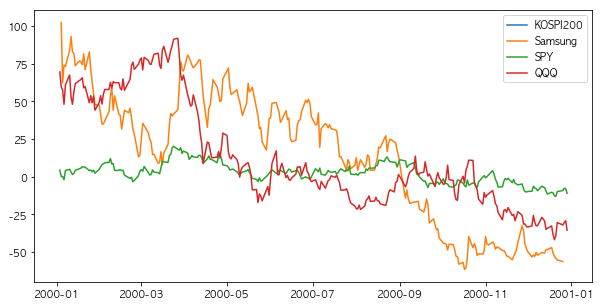

In [105]:
fig = plt.figure(figsize=(10,5))
fig.tight_layout()
subplot = fig.add_subplot(1,1,1)

for k, v in std_dict.items():
    if (k in ["KS200"]):
        name = v['stock_name']
        ticker_data = v['data']
        subplot.plot(ticker_data['prev_rate180'], label=name)
        subplot.legend()
for k, v in ticker_dict.items():
    if (k in ["005930.KS", "064350.KS", "102110.KS", "SPY", "QQQ"]):
        name = v['stock_name']
        ticker_data = v['data']
        subplot.plot(ticker_data['prev_rate180'], label=name)
        subplot.legend()
plt.show()

## 차트 - 100기준 수익률

2021-09-22 22:03:01,252 - DEBUG - update_title_pos
2021-09-22 22:03:01,312 - DEBUG - update_title_pos
2021-09-22 22:03:01,348 - DEBUG - update_title_pos
2021-09-22 22:03:01,368 - DEBUG - update_title_pos


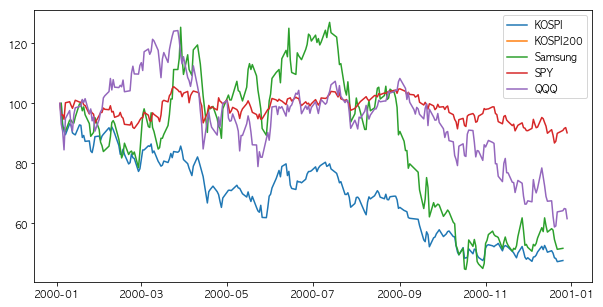

In [104]:
fig = plt.figure(figsize=(10,5))
fig.tight_layout()
subplot = fig.add_subplot(1,1,1)

for k, v in std_dict.items():
    name = v['stock_name']
    ticker_data = v['data']
    subplot.plot(ticker_data['relative_value'], label=name)
    subplot.legend()
for k, v in ticker_dict.items():
    if (k in ["005930.KS", "064350.KS", "102110.KS", "SPY", "QQQ"]):
        name = v['stock_name']
        ticker_data = v['data']
        subplot.plot(ticker_data['relative_value'], label=name)
        subplot.legend()
plt.show()

## 차트 - 개별 종목 가격, 이동평균

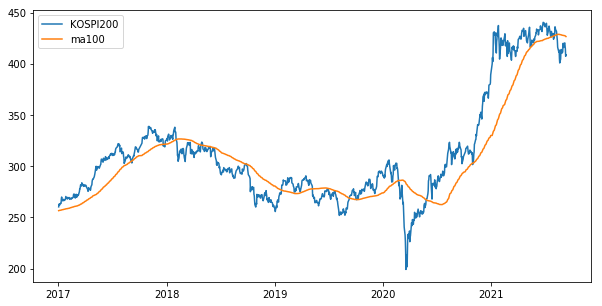

In [44]:
fig = plt.figure(figsize=(10,5))
fig.tight_layout()
subplot = fig.add_subplot(1,1,1)
    
code = "KS200"
ticker_data = std_dict[code]['data']
subplot.plot(ticker_data['Close'], label=std_dict[code]['stock_name'])
#subplot.plot(ticker_data['ma5'], label='ma5')
#subplot.plot(ticker_data['ma25'], label='ma25')
#subplot.plot(ticker_data['ma50'], label='ma50')
subplot.plot(ticker_data['ma100'], label='ma100')
subplot.legend()
plt.show()

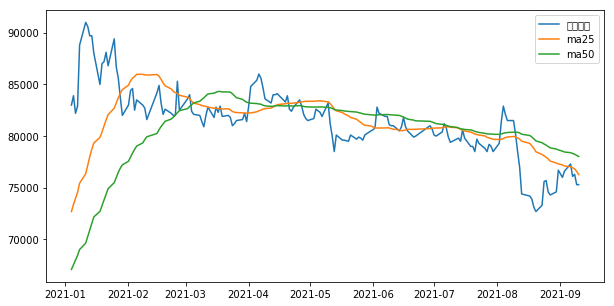

In [74]:
fig = plt.figure(figsize=(10,5))
fig.tight_layout()
subplot = fig.add_subplot(1,1,1)
    
code = "005930.KS"
ticker_data = ticker_dict[code]['data']
subplot.plot(ticker_data['Close'], label=ticker_dict[code]['stock_name'])
#subplot.plot(ticker_data['ma5'], label='ma5')
subplot.plot(ticker_data['ma25'], label='ma25')
subplot.plot(ticker_data['ma50'], label='ma50')
#subplot.plot(ticker_data['ma100'], label='ma100')
subplot.legend()
plt.show()

,High,Low,Open,Close,Volume,Adj Close,prev_close01,prev_close180,prev_rate180,relative_value,ma5,ma25,ma50,ma100
2020-01-02,2185,2130,2135,2180,131658,2180,2115,2700,-19.259259,100.000000,2111.0,2144.8,2209.3,2191.4
2020-01-03,2190,2145,2160,2160,107168,2160,2180,2700,-20.000000,99.082569,2121.0,2143.2,2206.8,2192.1


# 자산 관리 - 종목 매수, 매도

In [235]:
class Stock:
    def __init__(self, code):
        self.code = code
        self.stock_name = stock_cache.get_stock_name(code)
        self.count = 0
        self.buy_price = 0
        self.buy_atr20 = 0
        self.highest_price = 0
        self.price = 0 # current price
        self.ammount = 0
        
    def get_profit_percent(self):
        p = (self.price-self.buy_price)/self.buy_price*100
        return round(p, 2)
    
    def get_profit_amount(self):
        return self.amount - self.buy_price*self.count
        
    def buy(self, count, price, atr20):
        self.count += count
        self.buy_price = price
        self.buy_atr20 = atr20
        self.price = price
        self.apply(price)
        
    def sell(self, count, price):
        self.count -= count
        self.price = price
        self.apply(price)
        
    def apply(self, price):
        self.price = price
        if (price > self.highest_price):
            self.highest_price = price
        self.amount = self.count * self.price
        
class Asset:
    def __init__(self, cash):
        self.stocks = { }
        self.cash = cash
        self.total = cash
    
    def get_stock_count(self):
        return len(self.stocks)
    
    def buy(self, code, count, price, atr20):
        stock = self.get_stock(code)
        
        amount = count * price
        self.cash -= amount # TODO cash 부족시
        stock.buy(count, price, atr20)
        self.eval()
        
    def get_buy_count(self, price):
        count = math.floor(self.cash / price)
        return count
    
    def sell(self, code, count, price):
        if (not self.is_stock(code)):
            print("Asset.sell(): stock not exist", code)
            return      
        stock = self.get_stock(code)
        if (count > stock.count):
            print("Asset.sell(): count=%d > stock.count=%d", count, stock.count)
            return
        
        amount = count * price
        self.cash += amount
        stock.sell(count, price)
        
        if (stock.count == 0):
            del self.stocks[code]
        self.eval()
        
    def sell_all(self, code, price):
        if (not self.is_stock(code)):
            print("Asset.sell(): stock not exist", code)
            return

        stock = self.get_stock(code)
        count = stock.count
        amount = count * price
        stock.sell(count, price)
        self.cash += amount
        
        if (stock.count == 0):
            del self.stocks[code]
        self.eval()
    
    def apply(self, code, price):
        if (self.is_stock(code)):
            stock = self.get_stock(code)
            stock.apply(price)
            self.eval()
        
    def get_stock(self, code):
        if code in self.stocks:
            return self.stocks[code]
        else:
            stock = Stock(code)
            self.stocks[code] = stock;
            return stock
        
    def is_stock(self, code):
        if code in self.stocks:
            return True
        return False
        
    def eval(self):
        stock_total = 0
        for k, v in self.stocks.items():
            stock_total += v.amount
        self.total = stock_total + self.cash
        return self.total
    
    def display(self):
        cash_percent = round(self.cash/self.total*100,2)
        log.info("Asset.display(): total=%d cash=%d cash_percent=%.2f", self.total, self.cash, cash_percent)
        for k, v in self.stocks.items():
            log.info("     code=%s stock_name=%s count=%d price=%.2f amount=%d highest_price=%.2f profit_percent=%.2f", \
                     v.code, v.stock_name, v.count, v.price, v.amount, v.highest_price, v.get_profit_percent())
            #print("    ", "code=", v.code, "stock_name=", v.stock_name, \
            #      "count=", v.count, "price=", v.price, "amount=", v.amount, \
            #      "highest_price=", v.highest_price, \
            #      "profit_percent=", v.get_profit_percent())


In [260]:
code = "005930.KS"
asset = Asset(10000000)
asset.buy(code, 10, 70000, 1000)
asset.apply(code, 80000)
asset.sell(code, 5, 90000)
asset.display()

2021-09-17 23:11:55,357 - INFO - Asset.display(): total=10200000 cash=9750000 cash_percent=95.59
2021-09-17 23:11:55,358 - INFO -      code=005930.KS stock_name=삼성전자 count=5 price=90000.00 amount=450000 highest_price=90000.00 profit_percent=28.57


# 종목 이벤트 이력

In [7]:
UNKNOWN_TREND = 0
DOWN_TREND = -1
UP_TREND = 1
class StockHistory:
    def __init__(self, code):
        self.code = code
        self.name = stock_cache.get_stock_name(code)
        self.trend = UNKNOWN_TREND
        self.event_histories = [ ]

class StockHistoryStore:
    def __init__(self):
        self.stock_histories = { }
        
    def get_stock_history(self, code):
        if code in self.stock_histories:
            return self.stock_histories[code]
        else:
            stock_history = StockHistory(code)
            self.stock_histories[code] = stock_history;
            return stock_history

# 시스템

In [8]:
def make_batch_data(idx):
    batch_data = pd.DataFrame()
    for k, v in ticker_dict.items():
        if (idx in v['data'].index):
            print("k=", k, "exist yes")
            copy = v['data'].loc[idx].copy()
            copy['code'] = k
            batch_data = batch_data.append(copy)
        else:
            print("k=", k, "exist no")
    return batch_data
#ticker_data = ticker_dict['005930.KS']['data']

batch_data = make_batch_data("2020-01-02")
batch_data.head(10)

""


In [242]:
class LTHM: # Long Trend High Momentum
    def __init__(self, max_percent=10, cash=100000000): # 1억원
        self.MAX_POSITION_PERCENT = max_percent # 전체 자산 대비 종목별 최대 비중
        self.RISK_PERCENT = 2 # 손실 위험
        self.MIN_TRADING_AMOUNT = 60 * 1000 * 1000 * 1200 # 6백억
        self.MIN_STOCK_PRICE = 6000 # 6천원 이상
        self.ATR_MULTIPLY = 2 # stop loss=ATR*ATR_MULTIPLY
        self.PROFIT_RESERVE_PERCENT = 15
        
        self.STOP_LOSS_PERCENT = 1
        self.MIN_PREV_RATE180 = 0
        self.MAX_BUY_PER_DAY = 2
        self.asset = Asset(cash)
        self.data = pd.DataFrame(columns=['total', 'cash'])
        self.stock_history_store = StockHistoryStore()
        self.action_histories = [ ]
        
    def set_asset(self, asset):
        self.asset = asset
    def set_data(self, data):
        self.data = data
    
    # 모든 종목에 대해 idx row를 합쳐 batch_data 생성
    def make_batch_data(self, idx):
        batch_data = pd.DataFrame()
        for k, v in ticker_dict.items():
            if (idx in v['data'].index):
                copy = v['data'].loc[idx].copy()
                copy['code'] = k
                batch_data = batch_data.append(copy)
        return batch_data
    
    def filter_batch_data(self, batch_data):  
        if (len(batch_data) == 0):
            return batch_data
        
        # 종목 거래 금액, 주가, 이동 평균 filter
        filtered_data = batch_data[\
            (batch_data['ata20'] > self.MIN_TRADING_AMOUNT) &\
            (batch_data['Close'] > self.MIN_STOCK_PRICE) &\
            (batch_data['ma25'] > batch_data['ma50']) &\
            (batch_data['prev_rate180'] >= 0)]
        return filtered_data
    
    def prioritize_batch_data(self, batch_data):
        return batch_data.sort_values(by='prev_rate180', ascending=False)
    
    def backtest(self):
        ticker_data = ticker_dict['005930.KS']['data'] # idx 가져오기 위해 삼성전자 종목 사용
        for idx, row in ticker_data.iterrows():
            self.apply(idx)

        add_relative_value(self.data, 'total') # total 값을 이용하여 relative_value 컬럼 추가
        return
    
    def backtest(self, year):
        start_idx = f"{year}-01-01"
        end_idx = f"{year}-12-31"
        ticker_data = ticker_dict['005930.KS']['data']
        ticker_data = ticker_data[start_idx:end_idx]
        for idx, row in ticker_data.iterrows():
            #log.debug("LTHM.backtest(): idx=%s", idx)
            self.apply(idx)

        add_relative_value(self.data, 'total') # total 값을 이용하여 relative_value 컬럼 추가
        return
    
    def apply(self, idx):       
        # 신규 종목 체크
        buy_per_day = 0
        if (self.is_ks200_satisfied(idx)):
            batch_data = self.make_batch_data(idx)
            batch_data = self.filter_batch_data(batch_data)
            batch_data = self.prioritize_batch_data(batch_data)
            #print("LTHM.apply():", "idx=", idx, "batch_data_len=", len(batch_data))
            for idx, row in batch_data.iterrows():
                if (self.get_available_position_percent() < self.MAX_POSITION_PERCENT/2): # 5% 이하면 break
                    break
#                if (not self.is_available_position()): # 10% 이하면 break
#                    break
                code = row['code']
                if (self.apply_buy(idx, code, row)):
                    buy_per_day += 1
                    if (buy_per_day >= self.MAX_BUY_PER_DAY):
                        break
            
        # 보유 종목 체크
        for k in list(self.asset.stocks.keys()):
            code = k
            ticker_data = ticker_dict[code]['data']
            if (idx in ticker_data.index):
                row = ticker_data.loc[idx]
                self.asset.apply(code, row['Close'])
                self.apply_sell(idx, code, row)
            else:
                log.debug("LTHM.apply(): ticker_data index not found, ignored: idx=%s code=%s", idx, code)

        self.data = self.data.append(pd.Series({'total':self.asset.total, 'cash':self.asset.cash}, index=self.data.columns, name=idx))
    
    def apply_buy(self, idx, code, row, use_risk=True):
        stock_history = self.stock_history_store.get_stock_history(code)        
        price = row['Close']
        atr20 = row['atr20']
        #self.asset.apply(code, price)
        
        # Check buy
        if (not self.asset.is_stock(code) and \
            self.is_uptrend(stock_history, idx, row)):
            return self.buy_position(idx, code, row, use_risk)
        return False

    def apply_sell(self, idx, code, row):                
        # Check sell
        if (self.asset.is_stock(code)):
            stock = self.asset.get_stock(code)
            if (self.is_stop_loss(stock, row) or self.is_profit_reserve(stock, row)):
                return self.sell_position(idx, code, row)
        return False

    ### Common ###
    # 포지션 매수
    def buy_position(self, idx, code, row, use_risk=True):
        price = row['Close']
        atr20 = row['atr20']
        
        # Check buy
        if (not self.asset.is_stock(code)):
            count = 0
            if (use_risk):
                count = self.get_buy_count_risk(price, atr20)
            else:
                count = self.get_buy_count_cash(price)
            if (count > 0):
                self.buy_count(idx, code, row, count)
                return True
        return False

    # 포지션 매도
    def sell_position(self, idx, code, row):                
        # Check sell
        if (self.asset.is_stock(code)):
            stock = self.asset.get_stock(code)
            count = stock.count
            self.sell_count(idx, code, row, count)
            return True
        return False
    
    # 부분 매수
    def buy_count(self, idx, code, row, count):
        stock_history = self.stock_history_store.get_stock_history(code)
        price = row['Close']
        atr20 = row['atr20']
        
        action = { "name": "buy", "idx": idx.strftime('%Y-%m-%d'), \
                  "code": code, "stock_name": stock_history.name, "count": count, "price": price, \
                 "prev_rate180": row['prev_rate180']}
        log.info("action=%s", str(action))
        self.asset.buy(code, count, price, atr20)
        self.asset.display()
        self.action_histories.append(action)
    
    # 부분 매도
    def sell_count(self, idx, code, row, count):
        stock_history = self.stock_history_store.get_stock_history(code)
        price = row['Close']
        atr20 = row['atr20']

        stock = self.asset.get_stock(code)
        action = {"name": "sell", \
                  "idx": idx.strftime('%Y-%m-%d'), \
                  "code": code, \
                  "stock_name": stock_history.name, \
                  "count": count, \
                  "price": price, \
                  "buy_price": stock.buy_price, \
                  "profit_percent": stock.get_profit_percent()}
        log.info("action=%s", str(action))
        self.asset.sell(code, count, price)
        self.asset.display()
        self.action_histories.append(action)
        
    def is_ks200_satisfied(self, idx):
        code = "KS200"
        ticker_data = std_dict[code]['data']
        row = ticker_data.loc[idx]
        if (row['Close'] > row['ma100']):
            return True
        return False
    
    # 총자산 대비 위험 비율
    def get_buy_count_risk(self, price, atr20):
        #if (not self.is_available_position()):
        #    return 0
        position_limit = self.get_position_limit() # 포지션 최대 금액
        position_risk_amount = math.floor(self.asset.total * self.RISK_PERCENT / 100) # 포지션 위험 부담 금액
        stop_loss_amount = atr20*self.ATR_MULTIPLY # 주당 위험 부담 금액
        
        # buy count(포지션 크기) 계산
        buy_count = math.floor(position_risk_amount / stop_loss_amount)
        position_amount = buy_count * price
        if (position_amount > position_limit):
            position_amount = position_limit
            buy_count = math.floor(position_amount / price)
            
        # cash limit
        cash_limit = self.get_cash_limit()
        if (position_amount > cash_limit):
            position_amount = cash_limit
            buy_count = math.floor(position_amount / price)
        #if (position_amount > self.asset.cash):
        #    buy_count = 0
        log.debug("LTHM.get_buy_count(): buy_count=%d position_amount=%d total=%d cash=%d position_limit=%d cash_limit=%d", \
                  buy_count, position_amount, self.asset.total, self.asset.cash, position_limit, cash_limit)
        #print(f"LTHM.get_buy_count(): buy_count={buy_count} position_amount={position_amount} \
        #    total={self.asset.total} cash={self.asset.cash} position_limit={position_limit} cash_limit={cash_limit}")
        return buy_count
    
    # 총자산 대비 금액 비율
    def get_buy_count_cash(self, price):       
        if (not self.is_available_position()):
            return 0
        position_cash = self.asset.total * self.MAX_POSITION_PERCENT / 100
        log.debug("LTHM.get_buy_count(): position_cash=%d", position_cash)
        return math.floor(position_cash / price)
    
    def get_position_limit(self):
        return math.floor(self.asset.total*self.MAX_POSITION_PERCENT/100)
    
    def get_cash_limit(self):
        one_percent_amount = self.asset.total*0.01
        if (self.asset.cash <= one_percent_amount):
            return 0
        return self.asset.cash - one_percent_amount
    
    def get_available_position_percent(self):
        return self.asset.cash/self.asset.total*100
    
    def is_available_position(self):
        if (self.asset.cash/self.asset.total*100 >= self.MAX_POSITION_PERCENT):
            return True
        return False
    
    def is_uptrend(self, stock_history, idx, row):
        if (row['ma25'] > row['ma50']):
            stock_history.trend = UP_TREND
            return True
        return False        

    def is_downtrend(self, stock_history, idx, row):
        if (row['ma25'] < row['ma50']):
            stock_history.trend = DOWN_TREND
            return True
        return False
    
    def is_stop_loss(self, stock, row):
        price = row['Close']
        #if (price < stock.buy_price and ((stock.buy_price-price)/stock.buy_price*100 >= self.STOP_LOSS_PERCENT)):
        #    print("LTHM.is_stop_loss():", "code=", stock.code, "stock_name=", stock.stock_name, \
        #          "buy_price=", stock.buy_price, "price=", price, "buy_atr20=", stock.buy_atr20)
        #    return True
        if (price < stock.buy_price and ((stock.buy_price-price) > stock.buy_atr20*self.ATR_MULTIPLY)):
            log.debug("LTHM.is_stop_loss(): code=%s stock_name=%s buy_price=%d price=%d buy_atr20=%d", \
                      stock.code, stock.stock_name, stock.buy_price, price, stock.buy_atr20)
            return True
        return False

    def is_profit_reserve(self, stock, row):
        price = row['Close']
        if (price < stock.highest_price*(1-self.PROFIT_RESERVE_PERCENT/100)):
            log.debug("LTHM.is_profit_reserve(): code=%s stock_name=%s buy_price=%d price=%d highest_price=%d", \
                      stock.code, stock.stock_name, stock.buy_price, price, stock.highest_price)
            return True
        return False
    
    def on_gold_cross(self, stock_history, idx, row):
        code = stock_history.code
        stock_name = stock_history.name
        if (stock_history.trend != UP_TREND and row['ma25'] > row['ma50']):
            stock_history.trend = UP_TREND
            event = { "idx": idx.strftime('%Y-%m-%d'), "code": code, "stock_name": stock_name, "name": "uptrend"}
            stock_history.event_histories.append(event)
            print("event:", event)
            return True
        return False
    
    def on_dead_cross(self, stock_history, idx, row):
        code = stock_history.code
        stock_name = stock_history.name
        if (stock_history.trend != DOWN_TREND and row['ma25'] < row['ma50']):
            stock_history.trend = DOWN_TREND
            event = { "idx": idx.strftime('%Y-%m-%d'), "code": code, "stock_name": stock_name, "name": "downtrend"}
            stock_history.event_histories.append(event)
            print("event:", event)
            return True
        return False


## 시스템 - max_percent=33

In [ ]:
system = LTHM(max_percent=33)
system.backtest()
#system.apply('2020-01-02')
#system.apply('2020-01-03')
#system.action_histories

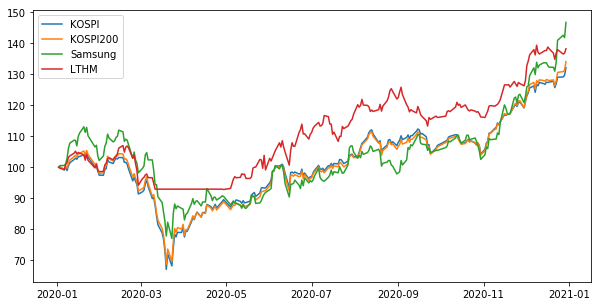

In [31]:
show_chart()

## 시스템 - max_percent=10

In [240]:
reset_dict()
system = LTHM(max_percent=10)

for year in range(2020,2021):
    load_std_dict(std_dict, year)
    load_ticker_dict(ticker_dict, year)
    system.backtest(year)

2021-09-22 23:51:00,050 - DEBUG - LTHM.get_buy_count(): buy_count=181 position_amount=10000000 total=100000000 cash=100000000 position_limit=10000000 cash_limit=99000000
2021-09-22 23:51:00,051 - INFO - action={'name': 'buy', 'idx': '2020-01-02', 'code': '005930.KS', 'stock_name': '삼성전자', 'count': 181, 'price': 55200.0, 'prev_rate180': 19.35}
2021-09-22 23:51:00,075 - INFO - Asset.display(): total=100000000 cash=90008800 cash_percent=90.01
2021-09-22 23:51:00,076 - INFO -      code=005930.KS stock_name=삼성전자 count=181 price=55200.00 amount=9991200 highest_price=55200.00 profit_percent=0.00
2021-09-22 23:51:00,950 - DEBUG - LTHM.is_stop_loss(): code=005930.KS stock_name=삼성전자 buy_price=55200 price=52100 buy_atr20=985
2021-09-22 23:51:00,951 - INFO - action={'name': 'sell', 'idx': '2020-03-11', 'code': '005930.KS', 'stock_name': '삼성전자', 'count': 181, 'price': 52100.0, 'buy_price': 55200.0, 'profit_percent': -5.62}
2021-09-22 23:51:00,951 - INFO - Asset.display(): total=99438900 cash=994389

2021-09-22 23:51:04,796 - DEBUG - update_title_pos
2021-09-22 23:51:04,854 - DEBUG - update_title_pos
2021-09-22 23:51:04,890 - DEBUG - update_title_pos
2021-09-22 23:51:04,911 - DEBUG - update_title_pos


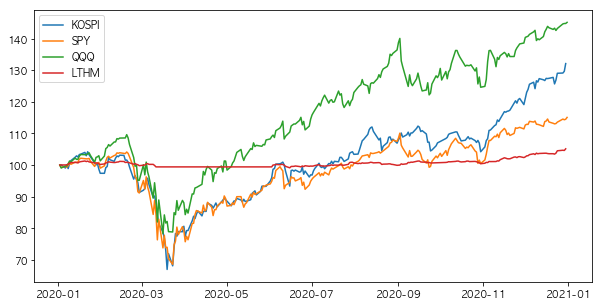

In [241]:
show_chart()

2021-09-17 16:59:34,799 - DEBUG - update_title_pos
2021-09-17 16:59:34,861 - DEBUG - update_title_pos
2021-09-17 16:59:34,904 - DEBUG - update_title_pos
2021-09-17 16:59:34,923 - DEBUG - update_title_pos


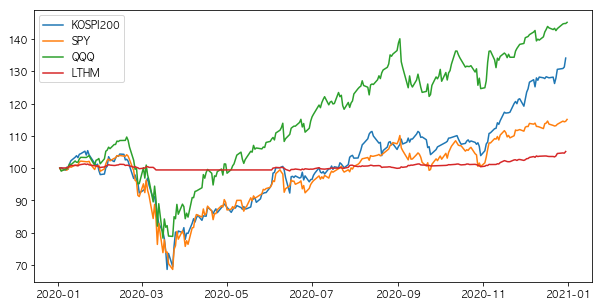

In [132]:
show_chart()

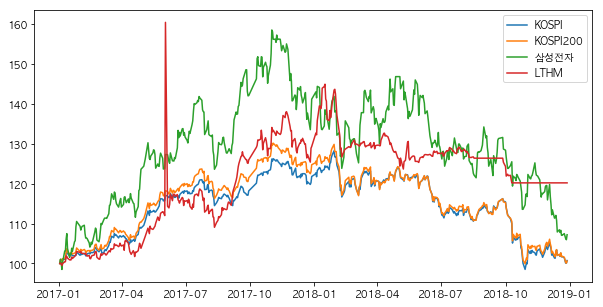

In [127]:
# 5atr stop loss, 15% preserve, 2 buy per day
show_chart()

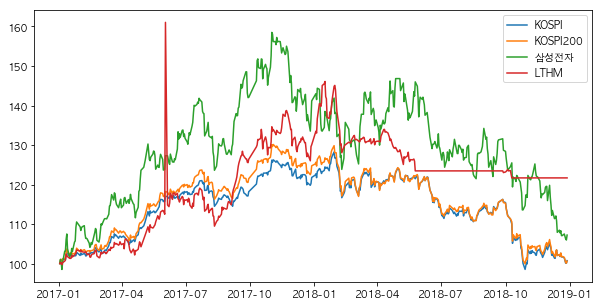

In [121]:
# 5atr stop loss, 15% preserve, 1 buy per day
show_chart()

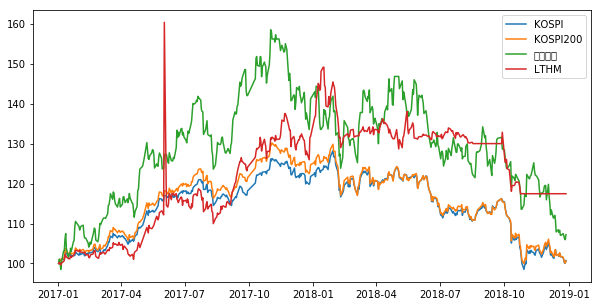

In [113]:
# 5atr stop loss, 15% preserve
show_chart()

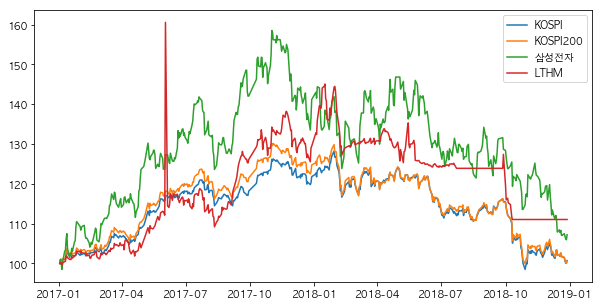

In [118]:
# 2atr stop loss, 15% perserve
show_chart()

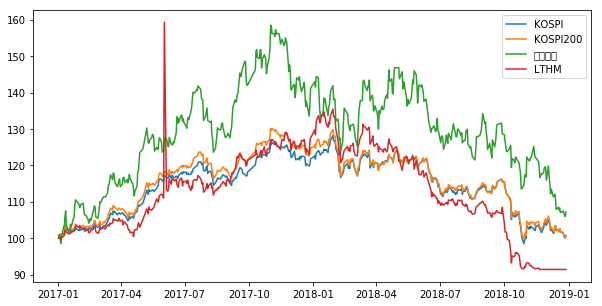

In [108]:
# 5atr stop loss, 25% preserve
show_chart()

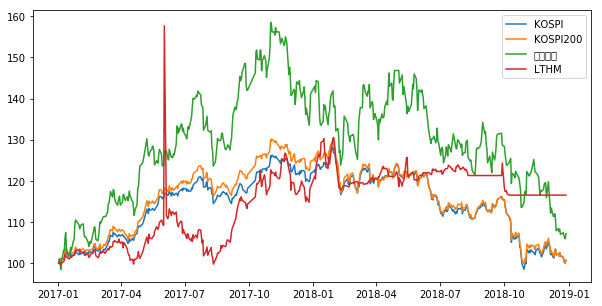

In [98]:
# 3% stop loss, 10% preserve
show_chart()

In [112]:
for year in range(2018,2019):
    load_std_dict(std_dict, year)
    load_ticker_dict(ticker_dict, year)
    system.backtest(year)

LTHM.get_buy_count(): buy_count=77 position_amount=13551632             total=135516322.4375 cash=34401606.4375 position_limit=13551632 cash_limit=33046443.213125
action: {'name': 'buy', 'idx': '2018-01-03', 'code': '035420.KS', 'stock_name': 'NAVER', 'count': 77, 'price': 174200.0, 'prev_rate180': 1.1614401858304297}
Asset.display(): total=135516322.4375 cash=20988206.4375 cash_percent=15.49
     code= 005490.KS stock_name= POSCO count= 38 price= 357500.0 amount= 13585000.0 highest_price= 357500.0 profit_percent= 37.24
     code= 051910.KS stock_name= LG화학 count= 38 price= 409500.0 amount= 15561000.0 highest_price= 423500.0 profit_percent= 51.95
     code= 009150.KS stock_name= 삼성전기 count= 103 price= 100000.0 amount= 10300000.0 highest_price= 112000.0 profit_percent= 0.7
     code= 068270.KS stock_name= 셀트리온 count= 104 price= 225829.0 amount= 23486216.0 highest_price= 225829.0 profit_percent= 132.13
     code= 066570.KS stock_name= LG전자 count= 137 price= 109500.0 amount= 15001500.0 hi

LTHM.get_buy_count(): buy_count=178 position_amount=5980800.0             total=139418514.4375 cash=41067114.4375 position_limit=13941851 cash_limit=39672929.293125
action: {'name': 'buy', 'idx': '2018-01-22', 'code': '009420.KS', 'stock_name': '한올바이오파마', 'count': 178, 'price': 33600.0, 'prev_rate180': 177.68595041322314}
Asset.display(): total=139418514.4375 cash=35086314.4375 cash_percent=25.17
     code= 005490.KS stock_name= POSCO count= 38 price= 385500.0 amount= 14649000.0 highest_price= 386500.0 profit_percent= 47.98
     code= 051910.KS stock_name= LG화학 count= 38 price= 423500.0 amount= 16093000.0 highest_price= 437000.0 profit_percent= 57.14
     code= 009150.KS stock_name= 삼성전기 count= 103 price= 101500.0 amount= 10454500.0 highest_price= 112000.0 profit_percent= 2.22
     code= 066570.KS stock_name= LG전자 count= 137 price= 107500.0 amount= 14727500.0 highest_price= 111000.0 profit_percent= 26.03
     code= 035420.KS stock_name= NAVER count= 77 price= 176200.0 amount= 13567400.

LTHM.get_buy_count(): buy_count=340 position_amount=4607000.0             total=131175063.4375 cash=106058063.4375 position_limit=13117506 cash_limit=104746312.803125
action: {'name': 'buy', 'idx': '2018-04-27', 'code': '006490.KS', 'stock_name': '인스코비', 'count': 340, 'price': 13550.0, 'prev_rate180': 642.4657534246576}
Asset.display(): total=131175063.4375 cash=101451063.4375 cash_percent=77.34
     code= 066570.KS stock_name= LG전자 count= 137 price= 101000.0 amount= 13837000.0 highest_price= 113500.0 profit_percent= 18.41
     code= 018260.KS stock_name= 삼성에스디에스 count= 47 price= 240000.0 amount= 11280000.0 highest_price= 260000.0 profit_percent= -7.16
     code= 006490.KS stock_name= 인스코비 count= 340 price= 13550.0 amount= 4607000.0 highest_price= 13550.0 profit_percent= 0.0
LTHM.get_buy_count(): buy_count=147 position_amount=2844450.0             total=131175063.4375 cash=101451063.4375 position_limit=13117506 cash_limit=100139312.803125
action: {'name': 'buy', 'idx': '2018-04-27', 'c

LTHM.is_profit_reserve(): code= 207940.KS stock_name= 삼성바이오로직스 buy_price= 506000.0 price= 404000.0 highest_price= 506000.0
action: {'name': 'sell', 'idx': '2018-05-02', 'code': '207940.KS', 'stock_name': '삼성바이오로직스', 'count': 22, 'price': 404000.0, 'buy_price': 506000.0, 'profit_percent': -20.16}
Asset.display(): total=131355652.203125 cash=45450713.4375 cash_percent=34.6
     code= 066570.KS stock_name= LG전자 count= 137 price= 102000.0 amount= 13974000.0 highest_price= 113500.0 profit_percent= 19.58
     code= 018260.KS stock_name= 삼성에스디에스 count= 47 price= 245000.0 amount= 11515000.0 highest_price= 260000.0 profit_percent= -5.22
     code= 006490.KS stock_name= 인스코비 count= 340 price= 12700.0 amount= 4318000.0 highest_price= 13550.0 profit_percent= -6.27
     code= 033180.KS stock_name= KH 필룩스 count= 147 price= 17100.0 amount= 2513700.0 highest_price= 19350.0 profit_percent= -11.63
     code= 005690.KS stock_name= 파미셀 count= 210 price= 17750.0 amount= 3727500.0 highest_price= 18700.0 pro

LTHM.is_profit_reserve(): code= 000660.KS stock_name= SK하이닉스 buy_price= 87100.0 price= 80500.0 highest_price= 95300.0
action: {'name': 'sell', 'idx': '2018-07-25', 'code': '000660.KS', 'stock_name': 'SK하이닉스', 'count': 150, 'price': 80500.0, 'buy_price': 87100.0, 'profit_percent': -7.58}
Asset.display(): total=132251675.25390625 cash=115292175.25390625 cash_percent=87.18
     code= 009150.KS stock_name= 삼성전기 count= 107 price= 158500.0 amount= 16959500.0 highest_price= 162500.0 profit_percent= 30.45
LTHM.is_profit_reserve(): code= 009150.KS stock_name= 삼성전기 buy_price= 121500.0 price= 137500.0 highest_price= 163000.0
action: {'name': 'sell', 'idx': '2018-08-17', 'code': '009150.KS', 'stock_name': '삼성전기', 'count': 107, 'price': 137500.0, 'buy_price': 121500.0, 'profit_percent': 13.17}
Asset.display(): total=130004675.25390625 cash=130004675.25390625 cash_percent=100.0
LTHM.get_buy_count(): buy_count=393 position_amount=12418800.0             total=130004675.25390625 cash=130004675.25390625

LTHM.is_profit_reserve(): code= 017800.KS stock_name= 현대엘리베이 buy_price= 77000.0 price= 75333.296875 highest_price= 111500.0
action: {'name': 'sell', 'idx': '2018-10-01', 'code': '017800.KS', 'stock_name': '현대엘리베이', 'count': 127, 'price': 75333.296875, 'buy_price': 77000.0, 'profit_percent': -2.16}
Asset.display(): total=127981603.95703125 cash=54648053.95703125 cash_percent=42.7
     code= 064350.KS stock_name= 현대로템 count= 393 price= 30900.0 amount= 12143700.0 highest_price= 31600.0 profit_percent= -2.22
     code= 002210.KS stock_name= 동성제약 count= 135 price= 31750.0 amount= 4286250.0 highest_price= 37200.0 profit_percent= -14.65
     code= 000720.KS stock_name= 현대건설 count= 192 price= 67800.0 amount= 13017600.0 highest_price= 67800.0 profit_percent= 0.59
     code= 009150.KS stock_name= 삼성전기 count= 85 price= 139000.0 amount= 11815000.0 highest_price= 142000.0 profit_percent= -2.11
     code= 006400.KS stock_name= 삼성SDI count= 49 price= 258500.0 amount= 12666500.0 highest_price= 261000.

In [92]:
asset=system.asset
system_data=system.data

In [94]:
system = LTHM(max_percent=10)
system.set_asset(asset)
system.set_data(system_data)

In [126]:
# qqq 70~100%, cash 0~30% rebalance
class DM3(LTHM):
    def __init__(self, max_percent=50, cash=100000000):
        self.REBALANCE_DAY = 1
        self.rebalance_date = pd.Timestamp(1970, 1, 1, 9)
        self.initial_buy = False
        self.highest_price = 0
        self.under_position = 0
        self.under_buy = [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        super().__init__(max_percent=max_percent, cash=cash)
        
    def filter_batch_data(self, batch_data):  
        if (len(batch_data) == 0):
            return batch_data
        
        # 종목 거래 금액, 주가, 이동 평균 filter
        filtered_data = batch_data[\
            (batch_data['ata20'] > self.MIN_TRADING_AMOUNT) &\
            (batch_data['Close'] > self.MIN_STOCK_PRICE) &\
            (batch_data['ma25'] > batch_data['ma50']) &\
            (batch_data['prev_rate180'] >= 0)]
        return filtered_data
    
    def prioritize_batch_data(self, batch_data):
        return batch_data.sort_values(by='prev_rate180', ascending=False)

    def backtest(self, year):
        start_idx = f"{year}-01-01"
        end_idx = f"{year}-12-31"
        ticker_data = ticker_dict['QQQ']['data']
        ticker_data = ticker_data[start_idx:end_idx]
        for idx, row in ticker_data.iterrows():
            log.debug("LTHM.backtest(): idx=%s price=%d", idx, row['Close'])
            self.apply(idx)

        add_relative_value(self.data, 'total') # total 값을 이용하여 relative_value 컬럼 추가
        return
    
    def apply(self, idx):
        # highest_price
        code = 'QQQ'
        ticker_data = ticker_dict[code]['data']
        row = ticker_data.loc[idx]
        price = row['Close']
        self.asset.apply(code, price) 

        if (price > self.highest_price):
            self.highest_price = price
            for i in range(len(self.under_buy)):
                self.under_buy[i] =  0
        
        # 최초 매수
        if (not self.initial_buy):
            self.apply_initial_buy(idx)
            
        under_position = self.get_under_position(price)
        if (self.under_position != under_position):
            self.under_position = under_position
            self.apply_rebalance(idx)
            
        # Rebalance
#        td = idx - self.rebalance_date
#        if (td.days > 1000):
#            self.apply_rebalance(idx)
#        if (idx.month != self.rebalance_date.month and idx.day >= self.REBALANCE_DAY):
#            self.apply_rebalance(idx)
        
        self.data = self.data.append(pd.Series({'total':self.asset.total, 'cash':self.asset.cash}, index=self.data.columns, name=idx))    
        return
    
    def apply_initial_buy(self, idx):
        code = 'QQQ'
        ticker_data = ticker_dict[code]['data']
        row = ticker_data.loc[idx]
        self.apply_stock_buy(idx, code, row)
        
        self.initial_buy = True
        self.highest_price = row['Close']
        self.rebalance_date = idx
                
    def apply_rebalance(self, idx):
        code = 'QQQ'
        ticker_data = ticker_dict[code]['data']
        row = ticker_data.loc[idx]
        price = row['Close']
        atr20 = row['atr20']
        
        max_position_percent = self.get_max_position_percent(price)
        stock_amount = self.asset.total - self.asset.cash
        max_amount = self.asset.total * max_position_percent / 100
        log.debug("DM.apply_rebalance(): stock_percent=%.2f", stock_amount/self.asset.total*100)
        if (stock_amount > max_amount):
            sell_cash = stock_amount - max_amount
            sell_count = math.ceil(sell_cash / price)
            self.sell_count(idx, code, sell_count, row)
        else:
            buy_cash = max_amount - stock_amount
            buy_count = math.floor(buy_cash / price)
            self.buy_count(idx, code, buy_count, row)
        
        self.rebalance_date = idx

    def get_under_position(self, price):
        unit = 15
        unit_price = self.highest_price * unit / 100
        diff = self.highest_price - price
        return int(diff / unit_price)

    def get_max_position_percent(self, price):
        unit = 15
        buy_percent = 10
        under_position = self.get_under_position(price)
        
        for i in range(len(self.under_buy)):
            if (i != 0 and i <= under_position):
                self.under_buy[i] = buy_percent
            if (i != 0 and i >= under_position+2):
                self.under_buy[i] = 0
        
        max_position = self.MAX_POSITION_PERCENT
        for r in self.under_buy:
            max_position += r
        return max_position
    
    def get_max_position_percent_old(self, price):
        if (price <= self.highest_price and price > self.highest_price * 0.9):
            self.under_buy[2] = self.under_buy[3] = 0
        elif (price <= self.highest_price * 0.9 and price > self.highest_price * 0.8):
            self.under_buy[1] = 10
            self.under_buy[3] = 0
        elif (price <= self.highest_price * 0.8 and price > self.highest_price * 0.7):
            self.under_buy[1] = self.under_buy[2] = 10
        elif (price <= self.highest_price * 0.7):
            self.under_buy[1] = self.under_buy[2] = self.under_buy[3] = 10
        return 70 + self.under_buy[1] + self.under_buy[2] + self.under_buy[3]
        
    def buy_count(self, idx, code, count, row):
        stock_history = self.stock_history_store.get_stock_history(code)
        price = row['Close']
        atr20 = row['atr20']
        
        action = { "name": "buy", "idx": idx.strftime('%Y-%m-%d'), \
                  "code": code, "stock_name": stock_history.name, "count": count, "price": price, \
                 "prev_rate180": row['prev_rate180']}
        log.info("action=%s", str(action))
        self.asset.buy(code, count, price, atr20)
        self.asset.display()
        self.action_histories.append(action)
        
    def sell_count(self, idx, code, count, row):
        stock_history = self.stock_history_store.get_stock_history(code)
        price = row['Close']
        atr20 = row['atr20']

        stock = self.asset.get_stock(code)
        action = {"name": "sell", \
                  "idx": idx.strftime('%Y-%m-%d'), \
                  "code": code, \
                  "stock_name": stock_history.name, \
                  "count": count, \
                  "price": price, \
                  "buy_price": stock.buy_price, \
                  "profit_percent": stock.get_profit_percent()}
        log.info("action=%s", str(action))
        self.asset.sell(code, count, price)
        self.asset.display()
        self.action_histories.append(action)
        
    def apply_stock_buy(self, idx, code, row):
        stock_history = self.stock_history_store.get_stock_history(code)
        price = row['Close']
        atr20 = row['atr20']
        
        # Check buy
        if (not self.asset.is_stock(code)):
            count = self.get_buy_count_cash(price)
            if (count > 0):
                action = { "name": "buy", "idx": idx.strftime('%Y-%m-%d'), \
                          "code": code, "stock_name": stock_history.name, "count": count, "price": price, \
                         "prev_rate180": row['prev_rate180']}
                log.info("action=%s", str(action))
                self.asset.buy(code, count, price, atr20)
                self.asset.display()
                self.action_histories.append(action)
                return True
        return False
    
    def apply_stock_sell(self, idx, code, row):
        stock_history = self.stock_history_store.get_stock_history(code)
        price = row['Close']
        atr20 = row['atr20']
        
        stock = self.asset.get_stock(code)
        count = stock.count                
        self.asset.sell_all(code, price)
        action = {"name": "sell", \
                  "idx": idx.strftime('%Y-%m-%d'), \
                  "code": code, \
                  "stock_name": stock_history.name, \
                  "count": count, \
                  "price": price, \
                  "buy_price": stock.buy_price, \
                  "profit_percent": stock.get_profit_percent()}
        log.info("action=%s", str(action))
        self.asset.display()
        self.action_histories.append(action)
        return True            
    

In [127]:
reset_dict()
system = DM3(max_percent=70)
system.highest_price = 10000
print("percent=", system.get_max_position_percent(9500))
print(system.under_buy)
print("percent=", system.get_max_position_percent(9000))
print(system.under_buy)
print("percent=", system.get_max_position_percent(8500))
print(system.under_buy)
print("percent=", system.get_max_position_percent(7500))
print(system.under_buy)
print("percent=", system.get_max_position_percent(8500))
print(system.under_buy)
print("percent=", system.get_max_position_percent(9500))
print(system.under_buy)

percent= 70
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
percent= 70
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
percent= 80
[0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0]
percent= 80
[0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0]
percent= 80
[0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0]
percent= 80
[0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [128]:
reset_dict()
system = DM3(max_percent=70)

for year in range(2011,2016):
    load_std_dict(std_dict, year)
    load_ticker_dict(ticker_dict, year)
    system.backtest(year)

2021-09-18 16:49:37,845 - DEBUG - LTHM.backtest(): idx=2011-01-03 00:00:00 price=55
2021-09-18 16:49:37,870 - DEBUG - LTHM.get_buy_count(): position_cash=70000000
2021-09-18 16:49:37,871 - INFO - action={'name': 'buy', 'idx': '2011-01-03', 'code': 'QQQ', 'stock_name': 'Unknown', 'count': 1265593, 'price': 55.3100013733, 'prev_rate180': 29.84}
2021-09-18 16:49:37,895 - INFO - Asset.display(): total=100000000 cash=30000049 cash_percent=30.00
2021-09-18 16:49:37,896 - INFO -      code=QQQ stock_name=Unknown count=1265593 price=55.31 amount=69999950 highest_price=55.31 profit_percent=0.00
2021-09-18 16:49:37,899 - DEBUG - LTHM.backtest(): idx=2011-01-04 00:00:00 price=55
2021-09-18 16:49:37,902 - DEBUG - LTHM.backtest(): idx=2011-01-05 00:00:00 price=55
2021-09-18 16:49:37,905 - DEBUG - LTHM.backtest(): idx=2011-01-06 00:00:00 price=55
2021-09-18 16:49:37,909 - DEBUG - LTHM.backtest(): idx=2011-01-07 00:00:00 price=55
2021-09-18 16:49:37,912 - DEBUG - LTHM.backtest(): idx=2011-01-10 00:00:

2021-09-18 16:49:38,200 - DEBUG - LTHM.backtest(): idx=2011-05-16 00:00:00 price=57
2021-09-18 16:49:38,203 - DEBUG - LTHM.backtest(): idx=2011-05-17 00:00:00 price=57
2021-09-18 16:49:38,207 - DEBUG - LTHM.backtest(): idx=2011-05-18 00:00:00 price=58
2021-09-18 16:49:38,211 - DEBUG - LTHM.backtest(): idx=2011-05-19 00:00:00 price=58
2021-09-18 16:49:38,215 - DEBUG - LTHM.backtest(): idx=2011-05-20 00:00:00 price=57
2021-09-18 16:49:38,219 - DEBUG - LTHM.backtest(): idx=2011-05-23 00:00:00 price=56
2021-09-18 16:49:38,223 - DEBUG - LTHM.backtest(): idx=2011-05-24 00:00:00 price=56
2021-09-18 16:49:38,226 - DEBUG - LTHM.backtest(): idx=2011-05-25 00:00:00 price=56
2021-09-18 16:49:38,230 - DEBUG - LTHM.backtest(): idx=2011-05-26 00:00:00 price=57
2021-09-18 16:49:38,233 - DEBUG - LTHM.backtest(): idx=2011-05-27 00:00:00 price=57
2021-09-18 16:49:38,236 - DEBUG - LTHM.backtest(): idx=2011-05-31 00:00:00 price=58
2021-09-18 16:49:38,240 - DEBUG - LTHM.backtest(): idx=2011-06-01 00:00:00 p

2021-09-18 16:49:38,459 - DEBUG - LTHM.backtest(): idx=2011-08-29 00:00:00 price=54
2021-09-18 16:49:38,464 - DEBUG - LTHM.backtest(): idx=2011-08-30 00:00:00 price=54
2021-09-18 16:49:38,469 - DEBUG - LTHM.backtest(): idx=2011-08-31 00:00:00 price=55
2021-09-18 16:49:38,473 - DEBUG - LTHM.backtest(): idx=2011-09-01 00:00:00 price=54
2021-09-18 16:49:38,477 - DEBUG - LTHM.backtest(): idx=2011-09-02 00:00:00 price=53
2021-09-18 16:49:38,480 - DEBUG - LTHM.backtest(): idx=2011-09-06 00:00:00 price=53
2021-09-18 16:49:38,484 - DEBUG - LTHM.backtest(): idx=2011-09-07 00:00:00 price=54
2021-09-18 16:49:38,489 - DEBUG - LTHM.backtest(): idx=2011-09-08 00:00:00 price=54
2021-09-18 16:49:38,493 - DEBUG - LTHM.backtest(): idx=2011-09-09 00:00:00 price=53
2021-09-18 16:49:38,496 - DEBUG - LTHM.backtest(): idx=2011-09-12 00:00:00 price=53
2021-09-18 16:49:38,499 - DEBUG - LTHM.backtest(): idx=2011-09-13 00:00:00 price=54
2021-09-18 16:49:38,503 - DEBUG - LTHM.backtest(): idx=2011-09-14 00:00:00 p

2021-09-18 16:49:39,020 - DEBUG - LTHM.backtest(): idx=2012-01-19 00:00:00 price=59
2021-09-18 16:49:39,023 - DEBUG - LTHM.backtest(): idx=2012-01-20 00:00:00 price=59
2021-09-18 16:49:39,027 - DEBUG - LTHM.backtest(): idx=2012-01-23 00:00:00 price=59
2021-09-18 16:49:39,031 - DEBUG - LTHM.backtest(): idx=2012-01-24 00:00:00 price=59
2021-09-18 16:49:39,035 - DEBUG - LTHM.backtest(): idx=2012-01-25 00:00:00 price=60
2021-09-18 16:49:39,039 - DEBUG - LTHM.backtest(): idx=2012-01-26 00:00:00 price=60
2021-09-18 16:49:39,042 - DEBUG - LTHM.backtest(): idx=2012-01-27 00:00:00 price=60
2021-09-18 16:49:39,046 - DEBUG - LTHM.backtest(): idx=2012-01-30 00:00:00 price=60
2021-09-18 16:49:39,050 - DEBUG - LTHM.backtest(): idx=2012-01-31 00:00:00 price=60
2021-09-18 16:49:39,054 - DEBUG - LTHM.backtest(): idx=2012-02-01 00:00:00 price=61
2021-09-18 16:49:39,058 - DEBUG - LTHM.backtest(): idx=2012-02-02 00:00:00 price=61
2021-09-18 16:49:39,062 - DEBUG - LTHM.backtest(): idx=2012-02-03 00:00:00 p

2021-09-18 16:49:39,424 - DEBUG - LTHM.backtest(): idx=2012-06-08 00:00:00 price=62
2021-09-18 16:49:39,428 - DEBUG - LTHM.backtest(): idx=2012-06-11 00:00:00 price=61
2021-09-18 16:49:39,432 - DEBUG - LTHM.backtest(): idx=2012-06-12 00:00:00 price=62
2021-09-18 16:49:39,436 - DEBUG - LTHM.backtest(): idx=2012-06-13 00:00:00 price=62
2021-09-18 16:49:39,440 - DEBUG - LTHM.backtest(): idx=2012-06-14 00:00:00 price=62
2021-09-18 16:49:39,444 - DEBUG - LTHM.backtest(): idx=2012-06-15 00:00:00 price=62
2021-09-18 16:49:39,448 - DEBUG - LTHM.backtest(): idx=2012-06-18 00:00:00 price=63
2021-09-18 16:49:39,452 - DEBUG - LTHM.backtest(): idx=2012-06-19 00:00:00 price=64
2021-09-18 16:49:39,457 - DEBUG - LTHM.backtest(): idx=2012-06-20 00:00:00 price=64
2021-09-18 16:49:39,462 - DEBUG - LTHM.backtest(): idx=2012-06-21 00:00:00 price=62
2021-09-18 16:49:39,465 - DEBUG - LTHM.backtest(): idx=2012-06-22 00:00:00 price=63
2021-09-18 16:49:39,469 - DEBUG - LTHM.backtest(): idx=2012-06-25 00:00:00 p

2021-09-18 16:49:40,381 - DEBUG - LTHM.backtest(): idx=2013-03-21 00:00:00 price=67
2021-09-18 16:49:40,384 - DEBUG - LTHM.backtest(): idx=2013-03-22 00:00:00 price=68
2021-09-18 16:49:40,388 - DEBUG - LTHM.backtest(): idx=2013-03-25 00:00:00 price=68
2021-09-18 16:49:40,391 - DEBUG - LTHM.backtest(): idx=2013-03-26 00:00:00 price=68
2021-09-18 16:49:40,395 - DEBUG - LTHM.backtest(): idx=2013-03-27 00:00:00 price=68
2021-09-18 16:49:40,398 - DEBUG - LTHM.backtest(): idx=2013-03-28 00:00:00 price=68
2021-09-18 16:49:40,401 - DEBUG - LTHM.backtest(): idx=2013-04-01 00:00:00 price=68
2021-09-18 16:49:40,405 - DEBUG - LTHM.backtest(): idx=2013-04-02 00:00:00 price=69
2021-09-18 16:49:40,408 - DEBUG - LTHM.backtest(): idx=2013-04-03 00:00:00 price=68
2021-09-18 16:49:40,412 - DEBUG - LTHM.backtest(): idx=2013-04-04 00:00:00 price=68
2021-09-18 16:49:40,415 - DEBUG - LTHM.backtest(): idx=2013-04-05 00:00:00 price=67
2021-09-18 16:49:40,419 - DEBUG - LTHM.backtest(): idx=2013-04-08 00:00:00 p

2021-09-18 16:49:40,731 - DEBUG - LTHM.backtest(): idx=2013-08-09 00:00:00 price=76
2021-09-18 16:49:40,734 - DEBUG - LTHM.backtest(): idx=2013-08-12 00:00:00 price=76
2021-09-18 16:49:40,738 - DEBUG - LTHM.backtest(): idx=2013-08-13 00:00:00 price=77
2021-09-18 16:49:40,742 - DEBUG - LTHM.backtest(): idx=2013-08-14 00:00:00 price=76
2021-09-18 16:49:40,746 - DEBUG - LTHM.backtest(): idx=2013-08-15 00:00:00 price=75
2021-09-18 16:49:40,749 - DEBUG - LTHM.backtest(): idx=2013-08-16 00:00:00 price=75
2021-09-18 16:49:40,753 - DEBUG - LTHM.backtest(): idx=2013-08-19 00:00:00 price=75
2021-09-18 16:49:40,756 - DEBUG - LTHM.backtest(): idx=2013-08-20 00:00:00 price=75
2021-09-18 16:49:40,760 - DEBUG - LTHM.backtest(): idx=2013-08-21 00:00:00 price=75
2021-09-18 16:49:40,764 - DEBUG - LTHM.backtest(): idx=2013-08-22 00:00:00 price=76
2021-09-18 16:49:40,767 - DEBUG - LTHM.backtest(): idx=2013-08-23 00:00:00 price=76
2021-09-18 16:49:40,771 - DEBUG - LTHM.backtest(): idx=2013-08-26 00:00:00 p

2021-09-18 16:49:41,094 - DEBUG - LTHM.backtest(): idx=2013-12-30 00:00:00 price=87
2021-09-18 16:49:41,098 - DEBUG - LTHM.backtest(): idx=2013-12-31 00:00:00 price=87
2021-09-18 16:49:41,272 - DEBUG - LTHM.backtest(): idx=2014-01-02 00:00:00 price=87
2021-09-18 16:49:41,276 - DEBUG - LTHM.backtest(): idx=2014-01-03 00:00:00 price=86
2021-09-18 16:49:41,278 - DEBUG - LTHM.backtest(): idx=2014-01-06 00:00:00 price=86
2021-09-18 16:49:41,281 - DEBUG - LTHM.backtest(): idx=2014-01-07 00:00:00 price=87
2021-09-18 16:49:41,284 - DEBUG - LTHM.backtest(): idx=2014-01-08 00:00:00 price=87
2021-09-18 16:49:41,287 - DEBUG - LTHM.backtest(): idx=2014-01-09 00:00:00 price=87
2021-09-18 16:49:41,290 - DEBUG - LTHM.backtest(): idx=2014-01-10 00:00:00 price=87
2021-09-18 16:49:41,293 - DEBUG - LTHM.backtest(): idx=2014-01-13 00:00:00 price=86
2021-09-18 16:49:41,297 - DEBUG - LTHM.backtest(): idx=2014-01-14 00:00:00 price=87
2021-09-18 16:49:41,300 - DEBUG - LTHM.backtest(): idx=2014-01-15 00:00:00 p

2021-09-18 16:49:42,062 - DEBUG - LTHM.backtest(): idx=2014-10-08 00:00:00 price=98
2021-09-18 16:49:42,066 - DEBUG - LTHM.backtest(): idx=2014-10-09 00:00:00 price=96
2021-09-18 16:49:42,069 - DEBUG - LTHM.backtest(): idx=2014-10-10 00:00:00 price=94
2021-09-18 16:49:42,073 - DEBUG - LTHM.backtest(): idx=2014-10-13 00:00:00 price=92
2021-09-18 16:49:42,076 - DEBUG - LTHM.backtest(): idx=2014-10-14 00:00:00 price=92
2021-09-18 16:49:42,080 - DEBUG - LTHM.backtest(): idx=2014-10-15 00:00:00 price=92
2021-09-18 16:49:42,083 - DEBUG - LTHM.backtest(): idx=2014-10-16 00:00:00 price=91
2021-09-18 16:49:42,087 - DEBUG - LTHM.backtest(): idx=2014-10-17 00:00:00 price=93
2021-09-18 16:49:42,090 - DEBUG - LTHM.backtest(): idx=2014-10-20 00:00:00 price=94
2021-09-18 16:49:42,093 - DEBUG - LTHM.backtest(): idx=2014-10-21 00:00:00 price=96
2021-09-18 16:49:42,097 - DEBUG - LTHM.backtest(): idx=2014-10-22 00:00:00 price=96
2021-09-18 16:49:42,101 - DEBUG - LTHM.backtest(): idx=2014-10-23 00:00:00 p

2021-09-18 16:49:42,584 - DEBUG - LTHM.backtest(): idx=2015-02-27 00:00:00 price=108
2021-09-18 16:49:42,587 - DEBUG - LTHM.backtest(): idx=2015-03-02 00:00:00 price=109
2021-09-18 16:49:42,590 - DEBUG - LTHM.backtest(): idx=2015-03-03 00:00:00 price=108
2021-09-18 16:49:42,594 - DEBUG - LTHM.backtest(): idx=2015-03-04 00:00:00 price=108
2021-09-18 16:49:42,598 - DEBUG - LTHM.backtest(): idx=2015-03-05 00:00:00 price=108
2021-09-18 16:49:42,601 - DEBUG - LTHM.backtest(): idx=2015-03-06 00:00:00 price=107
2021-09-18 16:49:42,605 - DEBUG - LTHM.backtest(): idx=2015-03-09 00:00:00 price=107
2021-09-18 16:49:42,609 - DEBUG - LTHM.backtest(): idx=2015-03-10 00:00:00 price=105
2021-09-18 16:49:42,612 - DEBUG - LTHM.backtest(): idx=2015-03-11 00:00:00 price=105
2021-09-18 16:49:42,616 - DEBUG - LTHM.backtest(): idx=2015-03-12 00:00:00 price=105
2021-09-18 16:49:42,620 - DEBUG - LTHM.backtest(): idx=2015-03-13 00:00:00 price=105
2021-09-18 16:49:42,624 - DEBUG - LTHM.backtest(): idx=2015-03-16

2021-09-18 16:49:43,293 - DEBUG - LTHM.backtest(): idx=2015-12-02 00:00:00 price=114
2021-09-18 16:49:43,296 - DEBUG - LTHM.backtest(): idx=2015-12-03 00:00:00 price=112
2021-09-18 16:49:43,300 - DEBUG - LTHM.backtest(): idx=2015-12-04 00:00:00 price=115
2021-09-18 16:49:43,304 - DEBUG - LTHM.backtest(): idx=2015-12-07 00:00:00 price=114
2021-09-18 16:49:43,307 - DEBUG - LTHM.backtest(): idx=2015-12-08 00:00:00 price=114
2021-09-18 16:49:43,311 - DEBUG - LTHM.backtest(): idx=2015-12-09 00:00:00 price=112
2021-09-18 16:49:43,315 - DEBUG - LTHM.backtest(): idx=2015-12-10 00:00:00 price=113
2021-09-18 16:49:43,319 - DEBUG - LTHM.backtest(): idx=2015-12-11 00:00:00 price=110
2021-09-18 16:49:43,323 - DEBUG - LTHM.backtest(): idx=2015-12-14 00:00:00 price=111
2021-09-18 16:49:43,327 - DEBUG - LTHM.backtest(): idx=2015-12-15 00:00:00 price=112
2021-09-18 16:49:43,331 - DEBUG - LTHM.backtest(): idx=2015-12-16 00:00:00 price=113
2021-09-18 16:49:43,335 - DEBUG - LTHM.backtest(): idx=2015-12-17

In [129]:
for year in range(2016,2022):
    load_std_dict(std_dict, year)
    load_ticker_dict(ticker_dict, year)
    system.backtest(year)

2021-09-18 16:49:43,547 - DEBUG - LTHM.backtest(): idx=2016-01-04 00:00:00 price=109
2021-09-18 16:49:43,550 - DEBUG - LTHM.backtest(): idx=2016-01-05 00:00:00 price=109
2021-09-18 16:49:43,553 - DEBUG - LTHM.backtest(): idx=2016-01-06 00:00:00 price=108
2021-09-18 16:49:43,556 - DEBUG - LTHM.backtest(): idx=2016-01-07 00:00:00 price=104
2021-09-18 16:49:43,559 - DEBUG - LTHM.backtest(): idx=2016-01-08 00:00:00 price=104
2021-09-18 16:49:43,562 - DEBUG - LTHM.backtest(): idx=2016-01-11 00:00:00 price=104
2021-09-18 16:49:43,565 - DEBUG - LTHM.backtest(): idx=2016-01-12 00:00:00 price=105
2021-09-18 16:49:43,568 - DEBUG - LTHM.backtest(): idx=2016-01-13 00:00:00 price=101
2021-09-18 16:49:43,571 - DEBUG - LTHM.backtest(): idx=2016-01-14 00:00:00 price=104
2021-09-18 16:49:43,574 - DEBUG - LTHM.backtest(): idx=2016-01-15 00:00:00 price=100
2021-09-18 16:49:43,578 - DEBUG - LTHM.backtest(): idx=2016-01-19 00:00:00 price=101
2021-09-18 16:49:43,581 - DEBUG - LTHM.backtest(): idx=2016-01-20

2021-09-18 16:49:44,253 - DEBUG - LTHM.backtest(): idx=2016-09-20 00:00:00 price=117
2021-09-18 16:49:44,257 - DEBUG - LTHM.backtest(): idx=2016-09-21 00:00:00 price=118
2021-09-18 16:49:44,261 - DEBUG - LTHM.backtest(): idx=2016-09-22 00:00:00 price=119
2021-09-18 16:49:44,264 - DEBUG - LTHM.backtest(): idx=2016-09-23 00:00:00 price=118
2021-09-18 16:49:44,268 - DEBUG - LTHM.backtest(): idx=2016-09-26 00:00:00 price=117
2021-09-18 16:49:44,271 - DEBUG - LTHM.backtest(): idx=2016-09-27 00:00:00 price=118
2021-09-18 16:49:44,274 - DEBUG - LTHM.backtest(): idx=2016-09-28 00:00:00 price=118
2021-09-18 16:49:44,278 - DEBUG - LTHM.backtest(): idx=2016-09-29 00:00:00 price=117
2021-09-18 16:49:44,283 - DEBUG - LTHM.backtest(): idx=2016-09-30 00:00:00 price=118
2021-09-18 16:49:44,287 - DEBUG - LTHM.backtest(): idx=2016-10-03 00:00:00 price=118
2021-09-18 16:49:44,290 - DEBUG - LTHM.backtest(): idx=2016-10-04 00:00:00 price=118
2021-09-18 16:49:44,294 - DEBUG - LTHM.backtest(): idx=2016-10-05

2021-09-18 16:49:44,871 - DEBUG - LTHM.backtest(): idx=2017-02-08 00:00:00 price=126
2021-09-18 16:49:44,875 - DEBUG - LTHM.backtest(): idx=2017-02-09 00:00:00 price=126
2021-09-18 16:49:44,878 - DEBUG - LTHM.backtest(): idx=2017-02-10 00:00:00 price=127
2021-09-18 16:49:44,882 - DEBUG - LTHM.backtest(): idx=2017-02-13 00:00:00 price=128
2021-09-18 16:49:44,885 - DEBUG - LTHM.backtest(): idx=2017-02-14 00:00:00 price=128
2021-09-18 16:49:44,889 - DEBUG - LTHM.backtest(): idx=2017-02-15 00:00:00 price=129
2021-09-18 16:49:44,893 - DEBUG - LTHM.backtest(): idx=2017-02-16 00:00:00 price=129
2021-09-18 16:49:44,896 - DEBUG - LTHM.backtest(): idx=2017-02-17 00:00:00 price=129
2021-09-18 16:49:44,899 - DEBUG - LTHM.backtest(): idx=2017-02-21 00:00:00 price=130
2021-09-18 16:49:44,903 - DEBUG - LTHM.backtest(): idx=2017-02-22 00:00:00 price=130
2021-09-18 16:49:44,907 - DEBUG - LTHM.backtest(): idx=2017-02-23 00:00:00 price=130
2021-09-18 16:49:44,910 - DEBUG - LTHM.backtest(): idx=2017-02-24

2021-09-18 16:49:45,223 - DEBUG - LTHM.backtest(): idx=2017-06-28 00:00:00 price=140
2021-09-18 16:49:45,227 - DEBUG - LTHM.backtest(): idx=2017-06-29 00:00:00 price=137
2021-09-18 16:49:45,230 - DEBUG - LTHM.backtest(): idx=2017-06-30 00:00:00 price=137
2021-09-18 16:49:45,234 - DEBUG - LTHM.backtest(): idx=2017-07-03 00:00:00 price=136
2021-09-18 16:49:45,237 - DEBUG - LTHM.backtest(): idx=2017-07-05 00:00:00 price=137
2021-09-18 16:49:45,241 - DEBUG - LTHM.backtest(): idx=2017-07-06 00:00:00 price=136
2021-09-18 16:49:45,244 - DEBUG - LTHM.backtest(): idx=2017-07-07 00:00:00 price=137
2021-09-18 16:49:45,249 - DEBUG - LTHM.backtest(): idx=2017-07-10 00:00:00 price=138
2021-09-18 16:49:45,252 - DEBUG - LTHM.backtest(): idx=2017-07-11 00:00:00 price=139
2021-09-18 16:49:45,256 - DEBUG - LTHM.backtest(): idx=2017-07-12 00:00:00 price=140
2021-09-18 16:49:45,260 - DEBUG - LTHM.backtest(): idx=2017-07-13 00:00:00 price=141
2021-09-18 16:49:45,264 - DEBUG - LTHM.backtest(): idx=2017-07-14

2021-09-18 16:49:45,650 - DEBUG - LTHM.backtest(): idx=2017-11-14 00:00:00 price=153
2021-09-18 16:49:45,654 - DEBUG - LTHM.backtest(): idx=2017-11-15 00:00:00 price=152
2021-09-18 16:49:45,658 - DEBUG - LTHM.backtest(): idx=2017-11-16 00:00:00 price=154
2021-09-18 16:49:45,662 - DEBUG - LTHM.backtest(): idx=2017-11-17 00:00:00 price=153
2021-09-18 16:49:45,665 - DEBUG - LTHM.backtest(): idx=2017-11-20 00:00:00 price=153
2021-09-18 16:49:45,669 - DEBUG - LTHM.backtest(): idx=2017-11-21 00:00:00 price=155
2021-09-18 16:49:45,673 - DEBUG - LTHM.backtest(): idx=2017-11-22 00:00:00 price=155
2021-09-18 16:49:45,676 - DEBUG - LTHM.backtest(): idx=2017-11-24 00:00:00 price=156
2021-09-18 16:49:45,680 - DEBUG - LTHM.backtest(): idx=2017-11-27 00:00:00 price=156
2021-09-18 16:49:45,683 - DEBUG - LTHM.backtest(): idx=2017-11-28 00:00:00 price=156
2021-09-18 16:49:45,687 - DEBUG - LTHM.backtest(): idx=2017-11-29 00:00:00 price=153
2021-09-18 16:49:45,690 - DEBUG - LTHM.backtest(): idx=2017-11-30

2021-09-18 16:49:46,584 - DEBUG - LTHM.backtest(): idx=2018-08-21 00:00:00 price=180
2021-09-18 16:49:46,588 - DEBUG - LTHM.backtest(): idx=2018-08-22 00:00:00 price=181
2021-09-18 16:49:46,592 - DEBUG - LTHM.backtest(): idx=2018-08-23 00:00:00 price=180
2021-09-18 16:49:46,596 - DEBUG - LTHM.backtest(): idx=2018-08-24 00:00:00 price=182
2021-09-18 16:49:46,599 - DEBUG - LTHM.backtest(): idx=2018-08-27 00:00:00 price=184
2021-09-18 16:49:46,603 - DEBUG - LTHM.backtest(): idx=2018-08-28 00:00:00 price=184
2021-09-18 16:49:46,607 - DEBUG - LTHM.backtest(): idx=2018-08-29 00:00:00 price=186
2021-09-18 16:49:46,673 - DEBUG - LTHM.backtest(): idx=2018-08-30 00:00:00 price=186
2021-09-18 16:49:46,676 - DEBUG - LTHM.backtest(): idx=2018-08-31 00:00:00 price=186
2021-09-18 16:49:46,680 - DEBUG - LTHM.backtest(): idx=2018-09-04 00:00:00 price=185
2021-09-18 16:49:46,683 - DEBUG - LTHM.backtest(): idx=2018-09-05 00:00:00 price=183
2021-09-18 16:49:46,687 - DEBUG - LTHM.backtest(): idx=2018-09-06

2021-09-18 16:49:47,506 - DEBUG - LTHM.backtest(): idx=2019-05-10 00:00:00 price=185
2021-09-18 16:49:47,510 - DEBUG - LTHM.backtest(): idx=2019-05-13 00:00:00 price=178
2021-09-18 16:49:47,514 - DEBUG - LTHM.backtest(): idx=2019-05-14 00:00:00 price=180
2021-09-18 16:49:47,517 - DEBUG - LTHM.backtest(): idx=2019-05-15 00:00:00 price=183
2021-09-18 16:49:47,521 - DEBUG - LTHM.backtest(): idx=2019-05-16 00:00:00 price=184
2021-09-18 16:49:47,525 - DEBUG - LTHM.backtest(): idx=2019-05-17 00:00:00 price=183
2021-09-18 16:49:47,529 - DEBUG - LTHM.backtest(): idx=2019-05-20 00:00:00 price=179
2021-09-18 16:49:47,532 - DEBUG - LTHM.backtest(): idx=2019-05-21 00:00:00 price=181
2021-09-18 16:49:47,536 - DEBUG - LTHM.backtest(): idx=2019-05-22 00:00:00 price=181
2021-09-18 16:49:47,540 - DEBUG - LTHM.backtest(): idx=2019-05-23 00:00:00 price=178
2021-09-18 16:49:47,543 - DEBUG - LTHM.backtest(): idx=2019-05-24 00:00:00 price=178
2021-09-18 16:49:47,547 - DEBUG - LTHM.backtest(): idx=2019-05-28

2021-09-18 16:49:47,921 - DEBUG - LTHM.backtest(): idx=2019-09-27 00:00:00 price=187
2021-09-18 16:49:47,925 - DEBUG - LTHM.backtest(): idx=2019-09-30 00:00:00 price=188
2021-09-18 16:49:47,928 - DEBUG - LTHM.backtest(): idx=2019-10-01 00:00:00 price=187
2021-09-18 16:49:47,932 - DEBUG - LTHM.backtest(): idx=2019-10-02 00:00:00 price=184
2021-09-18 16:49:47,935 - DEBUG - LTHM.backtest(): idx=2019-10-03 00:00:00 price=186
2021-09-18 16:49:47,939 - DEBUG - LTHM.backtest(): idx=2019-10-04 00:00:00 price=188
2021-09-18 16:49:47,942 - DEBUG - LTHM.backtest(): idx=2019-10-07 00:00:00 price=188
2021-09-18 16:49:47,946 - DEBUG - LTHM.backtest(): idx=2019-10-08 00:00:00 price=185
2021-09-18 16:49:47,949 - DEBUG - LTHM.backtest(): idx=2019-10-09 00:00:00 price=187
2021-09-18 16:49:47,952 - DEBUG - LTHM.backtest(): idx=2019-10-10 00:00:00 price=188
2021-09-18 16:49:47,956 - DEBUG - LTHM.backtest(): idx=2019-10-11 00:00:00 price=191
2021-09-18 16:49:47,960 - DEBUG - LTHM.backtest(): idx=2019-10-14

2021-09-18 16:49:48,441 - DEBUG - LTHM.backtest(): idx=2020-02-18 00:00:00 price=234
2021-09-18 16:49:48,444 - DEBUG - LTHM.backtest(): idx=2020-02-19 00:00:00 price=236
2021-09-18 16:49:48,448 - DEBUG - LTHM.backtest(): idx=2020-02-20 00:00:00 price=234
2021-09-18 16:49:48,451 - DEBUG - LTHM.backtest(): idx=2020-02-21 00:00:00 price=230
2021-09-18 16:49:48,455 - DEBUG - LTHM.backtest(): idx=2020-02-24 00:00:00 price=221
2021-09-18 16:49:48,458 - DEBUG - LTHM.backtest(): idx=2020-02-25 00:00:00 price=215
2021-09-18 16:49:48,462 - DEBUG - LTHM.backtest(): idx=2020-02-26 00:00:00 price=216
2021-09-18 16:49:48,465 - DEBUG - LTHM.backtest(): idx=2020-02-27 00:00:00 price=205
2021-09-18 16:49:48,468 - DEBUG - LTHM.backtest(): idx=2020-02-28 00:00:00 price=205
2021-09-18 16:49:48,472 - DEBUG - LTHM.backtest(): idx=2020-03-02 00:00:00 price=216
2021-09-18 16:49:48,475 - DEBUG - LTHM.backtest(): idx=2020-03-03 00:00:00 price=209
2021-09-18 16:49:48,479 - DEBUG - LTHM.backtest(): idx=2020-03-04

2021-09-18 16:49:49,216 - DEBUG - LTHM.backtest(): idx=2020-10-15 00:00:00 price=290
2021-09-18 16:49:49,220 - DEBUG - LTHM.backtest(): idx=2020-10-16 00:00:00 price=288
2021-09-18 16:49:49,224 - DEBUG - LTHM.backtest(): idx=2020-10-19 00:00:00 price=283
2021-09-18 16:49:49,228 - DEBUG - LTHM.backtest(): idx=2020-10-20 00:00:00 price=284
2021-09-18 16:49:49,231 - DEBUG - LTHM.backtest(): idx=2020-10-21 00:00:00 price=284
2021-09-18 16:49:49,235 - DEBUG - LTHM.backtest(): idx=2020-10-22 00:00:00 price=284
2021-09-18 16:49:49,238 - DEBUG - LTHM.backtest(): idx=2020-10-23 00:00:00 price=284
2021-09-18 16:49:49,242 - DEBUG - LTHM.backtest(): idx=2020-10-26 00:00:00 price=280
2021-09-18 16:49:49,245 - DEBUG - LTHM.backtest(): idx=2020-10-27 00:00:00 price=282
2021-09-18 16:49:49,249 - DEBUG - LTHM.backtest(): idx=2020-10-28 00:00:00 price=271
2021-09-18 16:49:49,252 - DEBUG - LTHM.backtest(): idx=2020-10-29 00:00:00 price=276
2021-09-18 16:49:49,256 - DEBUG - LTHM.backtest(): idx=2020-10-30

2021-09-18 16:49:49,757 - DEBUG - LTHM.backtest(): idx=2021-03-08 00:00:00 price=299
2021-09-18 16:49:49,761 - DEBUG - LTHM.backtest(): idx=2021-03-09 00:00:00 price=311
2021-09-18 16:49:49,765 - DEBUG - LTHM.backtest(): idx=2021-03-10 00:00:00 price=310
2021-09-18 16:49:49,768 - DEBUG - LTHM.backtest(): idx=2021-03-11 00:00:00 price=318
2021-09-18 16:49:49,773 - DEBUG - LTHM.backtest(): idx=2021-03-12 00:00:00 price=315
2021-09-18 16:49:49,776 - DEBUG - LTHM.backtest(): idx=2021-03-15 00:00:00 price=318
2021-09-18 16:49:49,780 - DEBUG - LTHM.backtest(): idx=2021-03-16 00:00:00 price=320
2021-09-18 16:49:49,783 - DEBUG - LTHM.backtest(): idx=2021-03-17 00:00:00 price=321
2021-09-18 16:49:49,787 - DEBUG - LTHM.backtest(): idx=2021-03-18 00:00:00 price=312
2021-09-18 16:49:49,790 - DEBUG - LTHM.backtest(): idx=2021-03-19 00:00:00 price=313
2021-09-18 16:49:49,793 - DEBUG - LTHM.backtest(): idx=2021-03-22 00:00:00 price=318
2021-09-18 16:49:49,797 - DEBUG - LTHM.backtest(): idx=2021-03-23

2021-09-18 16:49:50,164 - DEBUG - LTHM.backtest(): idx=2021-07-26 00:00:00 price=368
2021-09-18 16:49:50,168 - DEBUG - LTHM.backtest(): idx=2021-07-27 00:00:00 price=364
2021-09-18 16:49:50,172 - DEBUG - LTHM.backtest(): idx=2021-07-28 00:00:00 price=365
2021-09-18 16:49:50,175 - DEBUG - LTHM.backtest(): idx=2021-07-29 00:00:00 price=366
2021-09-18 16:49:50,178 - DEBUG - LTHM.backtest(): idx=2021-07-30 00:00:00 price=364
2021-09-18 16:49:50,182 - DEBUG - LTHM.backtest(): idx=2021-08-02 00:00:00 price=364
2021-09-18 16:49:50,185 - DEBUG - LTHM.backtest(): idx=2021-08-03 00:00:00 price=366
2021-09-18 16:49:50,189 - DEBUG - LTHM.backtest(): idx=2021-08-04 00:00:00 price=367
2021-09-18 16:49:50,192 - DEBUG - LTHM.backtest(): idx=2021-08-05 00:00:00 price=369
2021-09-18 16:49:50,196 - DEBUG - LTHM.backtest(): idx=2021-08-06 00:00:00 price=368
2021-09-18 16:49:50,199 - DEBUG - LTHM.backtest(): idx=2021-08-09 00:00:00 price=368
2021-09-18 16:49:50,203 - DEBUG - LTHM.backtest(): idx=2021-08-10

2021-09-18 16:49:50,302 - INFO - Asset.display(): total=506049135 cash=59900625 cash_percent=11.84
2021-09-18 16:49:50,303 - INFO -      code=QQQ stock_name=Unknown count=1180131 price=378.05 amount=446148510 highest_price=382.11 profit_percent=93.65


2021-09-18 16:49:50,347 - DEBUG - update_title_pos
2021-09-18 16:49:50,417 - DEBUG - update_title_pos
2021-09-18 16:49:50,462 - DEBUG - update_title_pos
2021-09-18 16:49:50,487 - DEBUG - update_title_pos


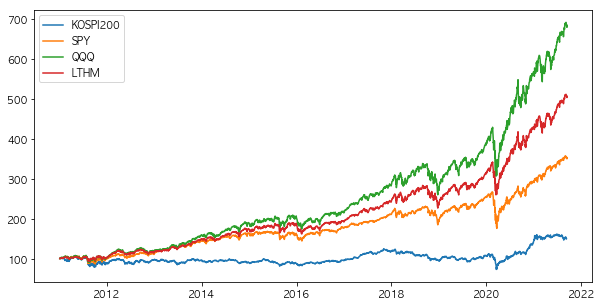

In [130]:
system.asset.display()
show_chart()

In [258]:
class DM(LTHM):
    def __init__(self, max_percent=100, cash=100000000):
        self.REBALANCE_DAY = 1
        self.rebalance_date = pd.Timestamp(1970, 1, 1, 9)
        super().__init__(max_percent=max_percent, cash=cash)
        
    def filter_batch_data(self, batch_data):  
        if (len(batch_data) == 0):
            return batch_data
        
        # 종목 거래 금액, 주가, 이동 평균 filter
        filtered_data = batch_data[\
            (batch_data['ata20'] > self.MIN_TRADING_AMOUNT) &\
            (batch_data['Close'] > self.MIN_STOCK_PRICE) &\
            (batch_data['ma25'] > batch_data['ma50']) &\
            (batch_data['prev_rate180'] >= 0)]
        return filtered_data
    
    def prioritize_batch_data(self, batch_data):
        return batch_data.sort_values(by='prev_rate180', ascending=False)

    def backtest(self, year):
        start_idx = f"{year}-01-01"
        end_idx = f"{year}-12-31"
        ticker_data = ticker_dict['SPY']['data']
        ticker_data = ticker_data[start_idx:end_idx]
        for idx, row in ticker_data.iterrows():
            #log.debug("LTHM.backtest(): idx=%s", idx)
            self.apply(idx)

        add_relative_value(self.data, 'total') # total 값을 이용하여 relative_value 컬럼 추가
        return
    
    def apply(self, idx):
        # 가격 반영
        for k in list(self.asset.stocks.keys()):
            code = k
            ticker_data = ticker_dict[code]['data']
            if (idx in ticker_data.index):
                row = ticker_data.loc[idx]
                price = row['Close']
                self.asset.apply(code, price) 
            else:
                log.debug("DM.apply(): ticker_data index not found, ignored: idx=%s code=%s", idx, code)
                
        # 매수 진입
        if (self.asset.get_stock_count() == 0):
            self.apply_initial_buy(idx)
            
        # Rebalance
        if (idx.month != self.rebalance_date.month and idx.day >= self.REBALANCE_DAY):
            self.apply_rebalance(idx)
        
        self.data = self.data.append(pd.Series({'total':self.asset.total, 'cash':self.asset.cash}, index=self.data.columns, name=idx))    
        return
    
    def apply_initial_buy(self, idx):
        batch_data = self.make_batch_data(idx)
        batch_data = self.prioritize_batch_data(batch_data)
        
        # 첫번째 선택
        highest_row = batch_data.iloc[0]
        highest_code = highest_row['code']
        #log.debug("apply(): 1st=%.2f 2nd=%.2f 3rd=%.2f", \
        #          batch_data.iloc[0]['prev_rate180'], batch_data.iloc[1]['prev_rate180'], batch_data.iloc[2]['prev_rate180'])
        if (highest_row['prev_rate180'] > 0):
            self.buy_position(idx, highest_code, highest_row, False)
            #self.apply_stock_buy(idx, highest_code, highest_row)
        
        self.initial_buy = True
        self.rebalance_date = idx
                
    def apply_rebalance(self, idx):
        #log.debug("DM.apply_rebalance(): idx=%s", idx))
        batch_data = self.make_batch_data(idx)
        batch_data = self.prioritize_batch_data(batch_data)
        
        # 첫번째 선택
        highest_row = batch_data.iloc[0]
        highest_code = highest_row['code']
        
        if (not self.asset.is_stock(highest_code)):
            self.apply_rebalance_stock_change(idx, highest_code, highest_row)
        else:
            self.apply_rebalance_stock_share(idx, highest_code, highest_row)

        self.rebalance_date = idx
        
    def apply_rebalance_stock_change(self, idx, highest_code, highest_row):
        # 기존 종목 전체 매도
        for k in list(self.asset.stocks.keys()):
            code = k
            ticker_data = ticker_dict[code]['data']
            if (idx in ticker_data.index):
                row = ticker_data.loc[idx]
                #self.apply_stock_sell(idx, code, row)
                self.sell_position(idx, code, row)

        # 신규 매수    
        if (highest_row['prev_rate180'] > 0):
            self.buy_position(idx, highest_code, highest_row, False)
            #self.apply_stock_buy(idx, highest_code, highest_row)
            
    def apply_rebalance_stock_share(self, idx, highest_code, highest_row):
        code = highest_code
        row = highest_row
        price = row['Close']
        atr20 = row['atr20']
        
        stock_amount = self.asset.total - self.asset.cash
        max_amount = self.asset.total * self.MAX_POSITION_PERCENT / 100
        log.debug("DM.apply_rebalance_stock_share(): stock_percent=%.2f", stock_amount/self.asset.total*100)
        if (stock_amount > max_amount):
            sell_cash = stock_amount - max_amount
            sell_count = math.ceil(sell_cash / price)
            self.sell_count(idx, code, row, sell_count)
        else:
            buy_cash = max_amount - stock_amount
            buy_count = math.floor(buy_cash / price)
            self.buy_count(idx, code, row, buy_count)        


In [259]:
reset_dict()
system = DM(max_percent=100)

for year in range(2000,2011):
    load_std_dict(std_dict, year)
    load_ticker_dict(ticker_dict, year)
    system.backtest(year)

2021-09-22 23:58:19,909 - DEBUG - LTHM.get_buy_count(): position_cash=100000000
2021-09-22 23:58:19,934 - INFO - action={'name': 'buy', 'idx': '2000-01-03', 'code': 'QQQ', 'stock_name': 'Unknown', 'count': 1059771, 'price': 94.36, 'prev_rate180': 69.41}
2021-09-22 23:58:19,958 - INFO - Asset.display(): total=100000000 cash=8 cash_percent=0.00
2021-09-22 23:58:19,959 - INFO -      code=QQQ stock_name=Unknown count=1059771 price=94.36 amount=99999991 highest_price=94.36 profit_percent=0.00


get_ticker_data(): ticker_data not enough: code=KS200 prev_len=0


2021-09-22 23:58:20,029 - DEBUG - DM.apply_rebalance_stock_share(): stock_percent=100.00
2021-09-22 23:58:20,030 - INFO - action={'name': 'buy', 'idx': '2000-02-01', 'code': 'QQQ', 'stock_name': 'Unknown', 'count': 0, 'price': 91.71, 'prev_rate180': 53.72}
2021-09-22 23:58:20,030 - INFO - Asset.display(): total=97191606 cash=8 cash_percent=0.00
2021-09-22 23:58:20,031 - INFO -      code=QQQ stock_name=Unknown count=1059771 price=91.71 amount=97191598 highest_price=95.85 profit_percent=0.00
2021-09-22 23:58:20,092 - DEBUG - DM.apply_rebalance_stock_share(): stock_percent=100.00
2021-09-22 23:58:20,093 - INFO - action={'name': 'buy', 'idx': '2000-03-01', 'code': 'QQQ', 'stock_name': 'Unknown', 'count': 0, 'price': 107.18, 'prev_rate180': 78.75}
2021-09-22 23:58:20,094 - INFO - Asset.display(): total=113586264 cash=8 cash_percent=0.00
2021-09-22 23:58:20,095 - INFO -      code=QQQ stock_name=Unknown count=1059771 price=107.18 amount=113586255 highest_price=107.18 profit_percent=0.00
2021-

get_ticker_data(): ticker_data not enough: code=KS200 prev_len=0


2021-09-22 23:58:21,117 - DEBUG - DM.apply_rebalance_stock_share(): stock_percent=100.00
2021-09-22 23:58:21,119 - INFO - action={'name': 'buy', 'idx': '2001-02-01', 'code': 'SPY', 'stock_name': 'Unknown', 'count': 0, 'price': 137.93, 'prev_rate180': -4.61}
2021-09-22 23:58:21,120 - INFO - Asset.display(): total=87527490 cash=8 cash_percent=0.00
2021-09-22 23:58:21,121 - INFO -      code=SPY stock_name=Unknown count=634579 price=137.93 amount=87527481 highest_price=152.50 profit_percent=0.00
2021-09-22 23:58:21,191 - DEBUG - DM.apply_rebalance_stock_share(): stock_percent=100.00
2021-09-22 23:58:21,192 - INFO - action={'name': 'buy', 'idx': '2001-03-01', 'code': 'SPY', 'stock_name': 'Unknown', 'count': 0, 'price': 124.6, 'prev_rate180': -17.92}
2021-09-22 23:58:21,192 - INFO - Asset.display(): total=79068552 cash=8 cash_percent=0.00
2021-09-22 23:58:21,193 - INFO -      code=SPY stock_name=Unknown count=634579 price=124.60 amount=79068543 highest_price=152.50 profit_percent=0.00
2021-0

2021-09-22 23:58:22,733 - INFO - Asset.display(): total=108022801 cash=390 cash_percent=0.00
2021-09-22 23:58:22,733 - INFO -      code=KS11 stock_name=Unknown count=134201 price=804.93 amount=108022410 highest_price=937.61 profit_percent=0.00
2021-09-22 23:58:22,741 - DEBUG - DM.apply(): ticker_data index not found, ignored: idx=2002-06-06 00:00:00 code=KS11
2021-09-22 23:58:22,752 - DEBUG - DM.apply(): ticker_data index not found, ignored: idx=2002-06-13 00:00:00 code=KS11
2021-09-22 23:58:22,780 - DEBUG - DM.apply(): ticker_data index not found, ignored: idx=2002-07-01 00:00:00 code=KS11
2021-09-22 23:58:22,823 - DEBUG - DM.apply(): ticker_data index not found, ignored: idx=2002-07-17 00:00:00 code=KS11
2021-09-22 23:58:22,874 - DEBUG - DM.apply_rebalance_stock_share(): stock_percent=100.00
2021-09-22 23:58:22,874 - INFO - action={'name': 'buy', 'idx': '2002-08-01', 'code': 'KS11', 'stock_name': 'Unknown', 'count': 0, 'price': 707.8, 'prev_rate180': -8.56}
2021-09-22 23:58:22,875 - 

2021-09-22 23:58:25,004 - INFO -      code=KS11 stock_name=Unknown count=149619 price=704.29 amount=105375165 highest_price=767.46 profit_percent=0.00
2021-09-22 23:58:25,010 - DEBUG - DM.apply(): ticker_data index not found, ignored: idx=2003-10-03 00:00:00 code=KS11
2021-09-22 23:58:25,084 - DEBUG - DM.apply_rebalance_stock_share(): stock_percent=100.00
2021-09-22 23:58:25,085 - INFO - action={'name': 'buy', 'idx': '2003-11-03', 'code': 'KS11', 'stock_name': 'Unknown', 'count': 0, 'price': 791.96, 'prev_rate180': 31.05}
2021-09-22 23:58:25,086 - INFO - Asset.display(): total=118492459 cash=196 cash_percent=0.00
2021-09-22 23:58:25,086 - INFO -      code=KS11 stock_name=Unknown count=149619 price=791.96 amount=118492263 highest_price=791.96 profit_percent=0.00
2021-09-22 23:58:25,155 - DEBUG - DM.apply_rebalance_stock_share(): stock_percent=100.00
2021-09-22 23:58:25,156 - INFO - action={'name': 'buy', 'idx': '2003-12-01', 'code': 'KS11', 'stock_name': 'Unknown', 'count': 0, 'price': 

2021-09-22 23:58:27,075 - INFO - action={'name': 'sell', 'idx': '2005-01-03', 'code': 'QQQ', 'stock_name': 'Unknown', 'count': 3107170, 'price': 39.34, 'buy_price': 39.75, 'profit_percent': -1.03}
2021-09-22 23:58:27,076 - INFO - Asset.display(): total=122236078 cash=122236078 cash_percent=100.00
2021-09-22 23:58:27,076 - DEBUG - LTHM.get_buy_count(): position_cash=122236078
2021-09-22 23:58:27,077 - INFO - action={'name': 'buy', 'idx': '2005-01-03', 'code': 'KS11', 'stock_name': 'Unknown', 'count': 136773, 'price': 893.71, 'prev_rate180': 17.83}
2021-09-22 23:58:27,103 - INFO - Asset.display(): total=122236078 cash=680 cash_percent=0.00
2021-09-22 23:58:27,104 - INFO -      code=KS11 stock_name=Unknown count=136773 price=893.71 amount=122235397 highest_price=893.71 profit_percent=0.00
2021-09-22 23:58:27,176 - DEBUG - DM.apply_rebalance_stock_share(): stock_percent=100.00
2021-09-22 23:58:27,177 - INFO - action={'name': 'buy', 'idx': '2005-02-01', 'code': 'KS11', 'stock_name': 'Unknow

2021-09-22 23:58:28,398 - INFO -      code=KS11 stock_name=Unknown count=136773 price=1379.75 amount=188712546 highest_price=1416.28 profit_percent=0.00
2021-09-22 23:58:28,439 - DEBUG - DM.apply(): ticker_data index not found, ignored: idx=2006-05-01 00:00:00 code=KS11
2021-09-22 23:58:28,465 - DEBUG - DM.apply(): ticker_data index not found, ignored: idx=2006-05-05 00:00:00 code=KS11
2021-09-22 23:58:28,505 - DEBUG - DM.apply(): ticker_data index not found, ignored: idx=2006-05-31 00:00:00 code=KS11
2021-09-22 23:58:28,526 - INFO - action={'name': 'sell', 'idx': '2006-06-01', 'code': 'KS11', 'stock_name': 'Unknown', 'count': 136773, 'price': 1295.09, 'buy_price': 1379.75, 'profit_percent': -6.14}
2021-09-22 23:58:28,527 - INFO - Asset.display(): total=177134024 cash=177134024 cash_percent=100.00
2021-09-22 23:58:28,528 - DEBUG - LTHM.get_buy_count(): position_cash=177134024
2021-09-22 23:58:28,528 - INFO - action={'name': 'buy', 'idx': '2006-06-01', 'code': 'SPY', 'stock_name': 'Unkn

2021-09-22 23:58:29,664 - INFO - Asset.display(): total=216360920 cash=1145 cash_percent=0.00
2021-09-22 23:58:29,665 - INFO -      code=KS11 stock_name=Unknown count=122144 price=1771.35 amount=216359774 highest_price=1807.85 profit_percent=0.00
2021-09-22 23:58:29,693 - DEBUG - DM.apply(): ticker_data index not found, ignored: idx=2007-07-17 00:00:00 code=KS11
2021-09-22 23:58:29,743 - DEBUG - DM.apply_rebalance_stock_share(): stock_percent=100.00
2021-09-22 23:58:29,743 - INFO - action={'name': 'buy', 'idx': '2007-08-01', 'code': 'KS11', 'stock_name': 'Unknown', 'count': 0, 'price': 1856.45, 'prev_rate180': 34.24}
2021-09-22 23:58:29,744 - INFO - Asset.display(): total=226755374 cash=1145 cash_percent=0.00
2021-09-22 23:58:29,745 - INFO -      code=KS11 stock_name=Unknown count=122144 price=1856.45 amount=226754228 highest_price=2004.22 profit_percent=0.00
2021-09-22 23:58:29,771 - DEBUG - DM.apply(): ticker_data index not found, ignored: idx=2007-08-15 00:00:00 code=KS11
2021-09-22

2021-09-22 23:58:32,172 - INFO - Asset.display(): total=169205784 cash=169205784 cash_percent=100.00
2021-09-22 23:58:34,436 - DEBUG - LTHM.get_buy_count(): position_cash=169205784
2021-09-22 23:58:34,437 - INFO - action={'name': 'buy', 'idx': '2009-04-07', 'code': 'KS11', 'stock_name': 'Unknown', 'count': 130148, 'price': 1300.1, 'prev_rate180': 1.04}
2021-09-22 23:58:34,458 - INFO - Asset.display(): total=169205784 cash=369 cash_percent=0.00
2021-09-22 23:58:34,459 - INFO -      code=KS11 stock_name=Unknown count=130148 price=1300.10 amount=169205414 highest_price=1300.10 profit_percent=0.00
2021-09-22 23:58:34,500 - DEBUG - DM.apply(): ticker_data index not found, ignored: idx=2009-05-01 00:00:00 code=KS11
2021-09-22 23:58:34,521 - DEBUG - DM.apply(): ticker_data index not found, ignored: idx=2009-05-05 00:00:00 code=KS11
2021-09-22 23:58:34,587 - DEBUG - DM.apply_rebalance_stock_share(): stock_percent=100.00
2021-09-22 23:58:34,588 - INFO - action={'name': 'buy', 'idx': '2009-06-01

2021-09-22 23:58:35,668 - INFO -      code=QQQ stock_name=Unknown count=4809216 price=49.93 amount=240124156 highest_price=50.52 profit_percent=0.00
2021-09-22 23:58:35,738 - DEBUG - DM.apply_rebalance_stock_share(): stock_percent=100.00
2021-09-22 23:58:35,739 - INFO - action={'name': 'buy', 'idx': '2010-06-01', 'code': 'QQQ', 'stock_name': 'Unknown', 'count': 0, 'price': 45.1800003052, 'prev_rate180': 4.27}
2021-09-22 23:58:35,739 - INFO - Asset.display(): total=217280393 cash=12 cash_percent=0.00
2021-09-22 23:58:35,740 - INFO -      code=QQQ stock_name=Unknown count=4809216 price=45.18 amount=217280380 highest_price=50.52 profit_percent=0.00
2021-09-22 23:58:35,817 - INFO - action={'name': 'sell', 'idx': '2010-07-01', 'code': 'QQQ', 'stock_name': 'Unknown', 'count': 4809216, 'price': 42.5900001526, 'buy_price': 45.1800003052, 'profit_percent': -5.73}
2021-09-22 23:58:35,817 - INFO - Asset.display(): total=204824523 cash=204824523 cash_percent=100.00
2021-09-22 23:58:35,818 - DEBUG 

In [261]:
for year in range(2011,2022):
    load_std_dict(std_dict, year)
    load_ticker_dict(ticker_dict, year)
    system.backtest(year)

2021-09-22 23:58:57,542 - DEBUG - DM.apply_rebalance_stock_share(): stock_percent=100.00
2021-09-22 23:58:57,543 - INFO - action={'name': 'buy', 'idx': '2011-01-03', 'code': 'QQQ', 'stock_name': 'Unknown', 'count': 0, 'price': 55.3100013733, 'prev_rate180': 29.84}
2021-09-22 23:58:57,544 - INFO - Asset.display(): total=243691529 cash=32 cash_percent=0.00
2021-09-22 23:58:57,544 - INFO -      code=QQQ stock_name=Unknown count=4405921 price=55.31 amount=243691496 highest_price=55.31 profit_percent=0.00
2021-09-22 23:58:57,615 - DEBUG - DM.apply_rebalance_stock_share(): stock_percent=100.00
2021-09-22 23:58:57,616 - INFO - action={'name': 'buy', 'idx': '2011-02-01', 'code': 'QQQ', 'stock_name': 'Unknown', 'count': 0, 'price': 57.0499992371, 'prev_rate180': 22.77}
2021-09-22 23:58:57,618 - INFO - Asset.display(): total=251357822 cash=32 cash_percent=0.00
2021-09-22 23:58:57,619 - INFO -      code=QQQ stock_name=Unknown count=4405921 price=57.05 amount=251357789 highest_price=57.18 profit_p

2021-09-22 23:58:59,076 - DEBUG - DM.apply_rebalance_stock_share(): stock_percent=100.00
2021-09-22 23:58:59,077 - INFO - action={'name': 'buy', 'idx': '2012-02-01', 'code': 'QQQ', 'stock_name': 'Unknown', 'count': 0, 'price': 61.0200004578, 'prev_rate180': 8.44}
2021-09-22 23:58:59,078 - INFO - Asset.display(): total=230629829 cash=38 cash_percent=0.00
2021-09-22 23:58:59,078 - INFO -      code=QQQ stock_name=Unknown count=3779577 price=61.02 amount=230629790 highest_price=61.02 profit_percent=0.00
2021-09-22 23:58:59,146 - DEBUG - DM.apply_rebalance_stock_share(): stock_percent=100.00
2021-09-22 23:58:59,147 - INFO - action={'name': 'buy', 'idx': '2012-03-01', 'code': 'QQQ', 'stock_name': 'Unknown', 'count': 0, 'price': 64.9199981689, 'prev_rate180': 18.1}
2021-09-22 23:58:59,148 - INFO - Asset.display(): total=245370170 cash=38 cash_percent=0.00
2021-09-22 23:58:59,149 - INFO -      code=QQQ stock_name=Unknown count=3779577 price=64.92 amount=245370131 highest_price=64.92 profit_per

2021-09-22 23:59:00,385 - INFO - Asset.display(): total=260429446 cash=93 cash_percent=0.00
2021-09-22 23:59:00,385 - INFO -      code=SPY stock_name=Unknown count=1668884 price=156.05 amount=260429353 highest_price=156.73 profit_percent=0.00
2021-09-22 23:59:00,455 - DEBUG - DM.apply_rebalance_stock_share(): stock_percent=100.00
2021-09-22 23:59:00,456 - INFO - action={'name': 'buy', 'idx': '2013-05-01', 'code': 'SPY', 'stock_name': 'Unknown', 'count': 0, 'price': 158.2799987793, 'prev_rate180': 11.98}
2021-09-22 23:59:00,457 - INFO - Asset.display(): total=264151051 cash=93 cash_percent=0.00
2021-09-22 23:59:00,458 - INFO -      code=SPY stock_name=Unknown count=1668884 price=158.28 amount=264150957 highest_price=159.68 profit_percent=0.00
2021-09-22 23:59:00,538 - DEBUG - DM.apply_rebalance_stock_share(): stock_percent=100.00
2021-09-22 23:59:00,539 - INFO - action={'name': 'buy', 'idx': '2013-06-03', 'code': 'SPY', 'stock_name': 'Unknown', 'count': 0, 'price': 164.3500061035, 'prev

2021-09-22 23:59:01,772 - DEBUG - DM.apply_rebalance_stock_share(): stock_percent=100.00
2021-09-22 23:59:01,773 - INFO - action={'name': 'buy', 'idx': '2014-07-01', 'code': 'QQQ', 'stock_name': 'Unknown', 'count': 0, 'price': 94.9400024414, 'prev_rate180': 8.64}
2021-09-22 23:59:01,773 - INFO - Asset.display(): total=347690925 cash=34 cash_percent=0.00
2021-09-22 23:59:01,773 - INFO -      code=QQQ stock_name=Unknown count=3662217 price=94.94 amount=347690890 highest_price=94.94 profit_percent=0.00
2021-09-22 23:59:01,850 - DEBUG - DM.apply_rebalance_stock_share(): stock_percent=100.00
2021-09-22 23:59:01,851 - INFO - action={'name': 'buy', 'idx': '2014-08-01', 'code': 'QQQ', 'stock_name': 'Unknown', 'count': 0, 'price': 94.6699981689, 'prev_rate180': 12.31}
2021-09-22 23:59:01,851 - INFO - Asset.display(): total=346702111 cash=34 cash_percent=0.00
2021-09-22 23:59:01,852 - INFO -      code=QQQ stock_name=Unknown count=3662217 price=94.67 amount=346702076 highest_price=97.23 profit_pe

2021-09-22 23:59:03,606 - INFO - Asset.display(): total=349803866 cash=85 cash_percent=0.00
2021-09-22 23:59:03,607 - INFO -      code=QQQ stock_name=Unknown count=3248851 price=107.67 amount=349803781 highest_price=107.67 profit_percent=0.00
2021-09-22 23:59:03,662 - DEBUG - DM.apply_rebalance_stock_share(): stock_percent=100.00
2021-09-22 23:59:03,663 - INFO - action={'name': 'buy', 'idx': '2015-11-02', 'code': 'QQQ', 'stock_name': 'Unknown', 'count': 0, 'price': 114.6100006104, 'prev_rate180': 7.4}
2021-09-22 23:59:03,663 - INFO - Asset.display(): total=372350900 cash=85 cash_percent=0.00
2021-09-22 23:59:03,664 - INFO -      code=QQQ stock_name=Unknown count=3248851 price=114.61 amount=372350815 highest_price=114.61 profit_percent=0.00
2021-09-22 23:59:03,738 - DEBUG - DM.apply_rebalance_stock_share(): stock_percent=100.00
2021-09-22 23:59:03,739 - INFO - action={'name': 'buy', 'idx': '2015-12-01', 'code': 'QQQ', 'stock_name': 'Unknown', 'count': 0, 'price': 115.1600036621, 'prev_r

2021-09-22 23:59:05,295 - DEBUG - DM.apply_rebalance_stock_share(): stock_percent=100.00
2021-09-22 23:59:05,296 - INFO - action={'name': 'buy', 'idx': '2017-01-03', 'code': 'QQQ', 'stock_name': 'Unknown', 'count': 0, 'price': 119.5400009155, 'prev_rate180': 10.6}
2021-09-22 23:59:05,296 - INFO - Asset.display(): total=389940324 cash=5 cash_percent=0.00
2021-09-22 23:59:05,297 - INFO -      code=QQQ stock_name=Unknown count=3262007 price=119.54 amount=389940319 highest_price=120.82 profit_percent=0.00
2021-09-22 23:59:05,366 - DEBUG - DM.apply_rebalance_stock_share(): stock_percent=100.00
2021-09-22 23:59:05,367 - INFO - action={'name': 'buy', 'idx': '2017-02-01', 'code': 'QQQ', 'stock_name': 'Unknown', 'count': 0, 'price': 125.4300003052, 'prev_rate180': 8.28}
2021-09-22 23:59:05,367 - INFO - Asset.display(): total=409153544 cash=5 cash_percent=0.00
2021-09-22 23:59:05,368 - INFO -      code=QQQ stock_name=Unknown count=3262007 price=125.43 amount=409153539 highest_price=125.80 profit

2021-09-22 23:59:06,522 - DEBUG - DM.apply_rebalance_stock_share(): stock_percent=100.00
2021-09-22 23:59:06,523 - INFO - action={'name': 'buy', 'idx': '2018-03-01', 'code': 'QQQ', 'stock_name': 'Unknown', 'count': 0, 'price': 164.4799957275, 'prev_rate180': 15.05}
2021-09-22 23:59:06,523 - INFO - Asset.display(): total=484393204 cash=110 cash_percent=0.00
2021-09-22 23:59:06,524 - INFO -      code=QQQ stock_name=Unknown count=2944997 price=164.48 amount=484393093 highest_price=170.93 profit_percent=0.00
2021-09-22 23:59:06,602 - DEBUG - DM.apply_rebalance_stock_share(): stock_percent=100.00
2021-09-22 23:59:06,603 - INFO - action={'name': 'buy', 'idx': '2018-04-02', 'code': 'QQQ', 'stock_name': 'Unknown', 'count': 0, 'price': 155.5099945068, 'prev_rate180': 7.69}
2021-09-22 23:59:06,603 - INFO - Asset.display(): total=457976577 cash=110 cash_percent=0.00
2021-09-22 23:59:06,604 - INFO -      code=QQQ stock_name=Unknown count=2944997 price=155.51 amount=457976467 highest_price=174.08 p

2021-09-22 23:59:08,606 - DEBUG - DM.apply_rebalance_stock_share(): stock_percent=100.00
2021-09-22 23:59:08,607 - INFO - action={'name': 'buy', 'idx': '2019-08-01', 'code': 'QQQ', 'stock_name': 'Unknown', 'count': 0, 'price': 190.1499938965, 'prev_rate180': 13.56}
2021-09-22 23:59:08,607 - INFO - Asset.display(): total=505310900 cash=31 cash_percent=0.00
2021-09-22 23:59:08,608 - INFO -      code=QQQ stock_name=Unknown count=2657433 price=190.15 amount=505310868 highest_price=195.29 profit_percent=0.00
2021-09-22 23:59:08,687 - DEBUG - DM.apply_rebalance_stock_share(): stock_percent=100.00
2021-09-22 23:59:08,688 - INFO - action={'name': 'buy', 'idx': '2019-09-03', 'code': 'QQQ', 'stock_name': 'Unknown', 'count': 0, 'price': 185.6499938965, 'prev_rate180': 6.97}
2021-09-22 23:59:08,689 - INFO - Asset.display(): total=493352451 cash=31 cash_percent=0.00
2021-09-22 23:59:08,689 - INFO -      code=QQQ stock_name=Unknown count=2657433 price=185.65 amount=493352420 highest_price=195.29 pro

2021-09-22 23:59:10,007 - DEBUG - DM.apply_rebalance_stock_share(): stock_percent=100.00
2021-09-22 23:59:10,007 - INFO - action={'name': 'buy', 'idx': '2020-11-02', 'code': 'QQQ', 'stock_name': 'Unknown', 'count': 0, 'price': 269.9800109863, 'prev_rate180': 24.04}
2021-09-22 23:59:10,008 - INFO - Asset.display(): total=705325838 cash=89 cash_percent=0.00
2021-09-22 23:59:10,009 - INFO -      code=QQQ stock_name=Unknown count=2612511 price=269.98 amount=705325748 highest_price=302.76 profit_percent=0.00
2021-09-22 23:59:10,084 - DEBUG - DM.apply_rebalance_stock_share(): stock_percent=100.00
2021-09-22 23:59:10,085 - INFO - action={'name': 'buy', 'idx': '2020-12-01', 'code': 'QQQ', 'stock_name': 'Unknown', 'count': 0, 'price': 303.4599914551, 'prev_rate180': 28.21}
2021-09-22 23:59:10,086 - INFO - Asset.display(): total=792792655 cash=89 cash_percent=0.00
2021-09-22 23:59:10,086 - INFO -      code=QQQ stock_name=Unknown count=2612511 price=303.46 amount=792792565 highest_price=303.46 pr

2021-09-22 23:59:11,061 - DEBUG - update_title_pos
2021-09-22 23:59:11,141 - DEBUG - update_title_pos
2021-09-22 23:59:11,184 - DEBUG - update_title_pos
2021-09-22 23:59:11,212 - DEBUG - update_title_pos


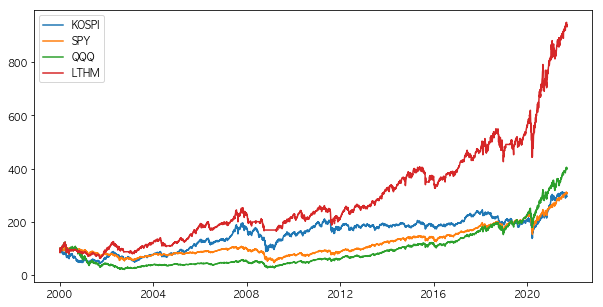

In [262]:
show_chart()

2021-09-22 18:31:25,240 - DEBUG - update_title_pos
2021-09-22 18:31:25,306 - DEBUG - update_title_pos
2021-09-22 18:31:25,340 - DEBUG - update_title_pos
2021-09-22 18:31:25,360 - DEBUG - update_title_pos


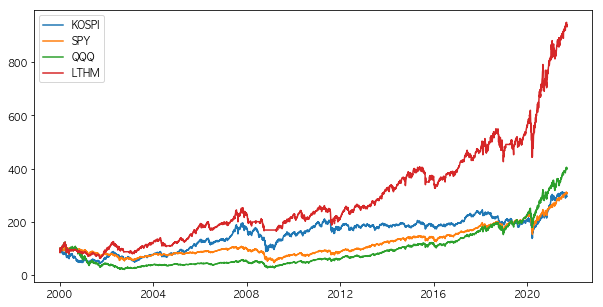

In [161]:
# 100%, 월1회 rebalance
show_chart()

2021-09-22 22:33:26,764 - DEBUG - update_title_pos
2021-09-22 22:33:26,838 - DEBUG - update_title_pos
2021-09-22 22:33:26,875 - DEBUG - update_title_pos
2021-09-22 22:33:26,896 - DEBUG - update_title_pos


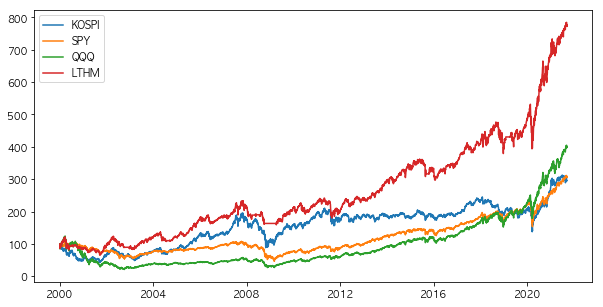

In [134]:
# 90%, 월1회 rebalance
show_chart()

2021-09-22 18:35:29,184 - DEBUG - update_title_pos
2021-09-22 18:35:29,249 - DEBUG - update_title_pos
2021-09-22 18:35:29,287 - DEBUG - update_title_pos
2021-09-22 18:35:29,306 - DEBUG - update_title_pos


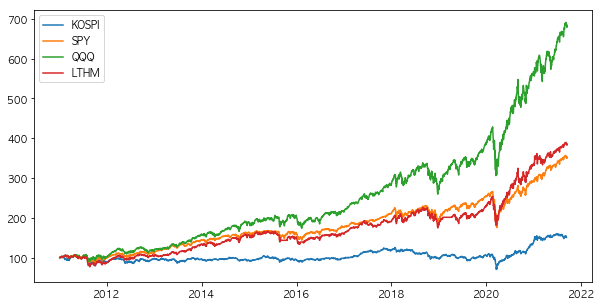

In [163]:
show_chart()